In [1]:
#importing libraries

import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import plotly.express as px
from pandas import plotting
import missingno as ms
from sklearn.impute import SimpleImputer
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from visualizer import Visualizer
from fancyimpute import KNN
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from itertools import product
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [2]:
plt.style.use("ggplot") #setting the plot style

In [3]:
df = pd.read_csv("Lead Scoring.csv")

In [4]:
df.shape

(9240, 37)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

We can see that there are lot of categorical columns available in our data. We have 4 columns with float values, 3 columns with integer values and 30 columns with categorical values.

<AxesSubplot:title={'center':'Null Values Plot'}>

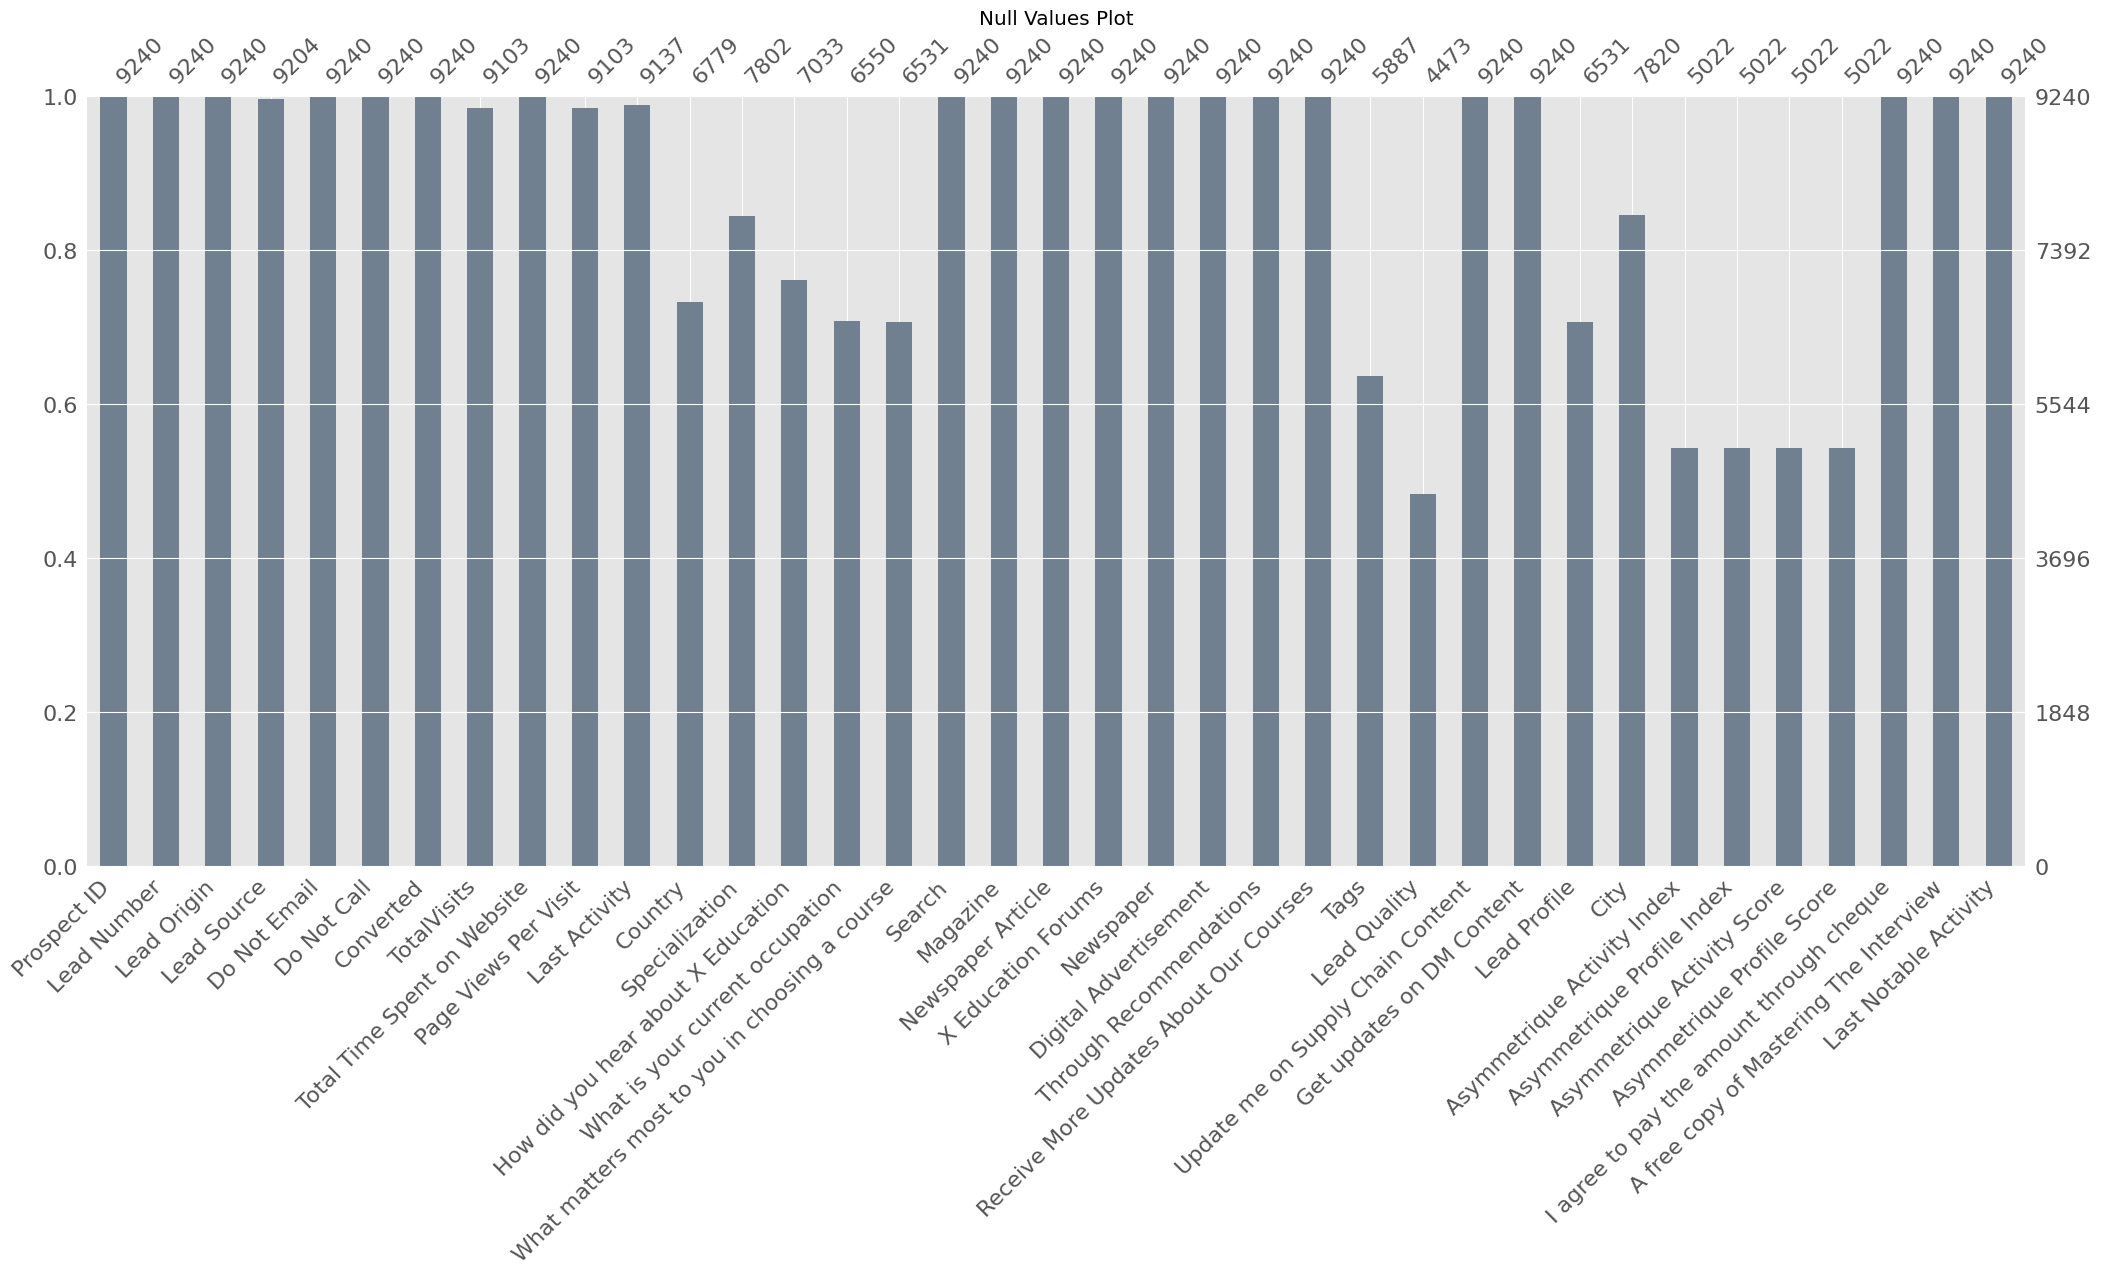

In [6]:
plt.title("Null Values Plot")
ms.bar(df, color = 'slategrey')

In [7]:
(df.isnull().sum()/df.shape[0]*100).sort_values(ascending = False)

Lead Quality                                     51.590909
Asymmetrique Activity Index                      45.649351
Asymmetrique Profile Score                       45.649351
Asymmetrique Activity Score                      45.649351
Asymmetrique Profile Index                       45.649351
Tags                                             36.287879
Lead Profile                                     29.318182
What matters most to you in choosing a course    29.318182
What is your current occupation                  29.112554
Country                                          26.634199
How did you hear about X Education               23.885281
Specialization                                   15.562771
City                                             15.367965
Page Views Per Visit                              1.482684
TotalVisits                                       1.482684
Last Activity                                     1.114719
Lead Source                                       0.3896

In [8]:
num_col = df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].keys()

In [9]:
cat_col = df.dtypes[~(df.dtypes == 'int64') & ~(df.dtypes == 'float64')].keys()

In [10]:
num_df = df[num_col]

In [11]:
cat_df = df[cat_col]

### Numerical Data Feature Enginnering

In [12]:
num_df

Lead Number  Converted  TotalVisits  Total Time Spent on Website  \
0          660737          0          0.0                            0   
1          660728          0          5.0                          674   
2          660727          1          2.0                         1532   
3          660719          0          1.0                          305   
4          660681          1          2.0                         1428   
...           ...        ...          ...                          ...   
9235       579564          1          8.0                         1845   
9236       579546          0          2.0                          238   
9237       579545          0          2.0                          199   
9238       579538          1          3.0                          499   
9239       579533          1          6.0                         1279   

      Page Views Per Visit  Asymmetrique Activity Score  \
0                     0.00                         15.0   
1                     2.50                         15.0   
2                     2.00                         14.0   
3                     1.00                         13.0   
4                     1.00                         15.0   
...                    ...                          ...   
9235                  2.67                         15.0   
9236                  2.00                         14.0   
9237                  2.00                         13.0   
9238                  3.00                         15.0   
9239                  3.00                         15.0   

      Asymmetrique Profile Score  
0                           15.0  
1                           15.0  
2                           20.0  
3                           17.0  
4                           18.0  
...                          ...  
9235                        17.0  
9236                        19.0  
9237                        20.0  
9238                        16.0  
9239                        18.0  

[9240 rows x 7 columns]

In [13]:
(num_df.isnull().sum()/num_df.shape[0]*100).sort_values(ascending = False)

Asymmetrique Activity Score    45.649351
Asymmetrique Profile Score     45.649351
TotalVisits                     1.482684
Page Views Per Visit            1.482684
Lead Number                     0.000000
Converted                       0.000000
Total Time Spent on Website     0.000000
dtype: float64

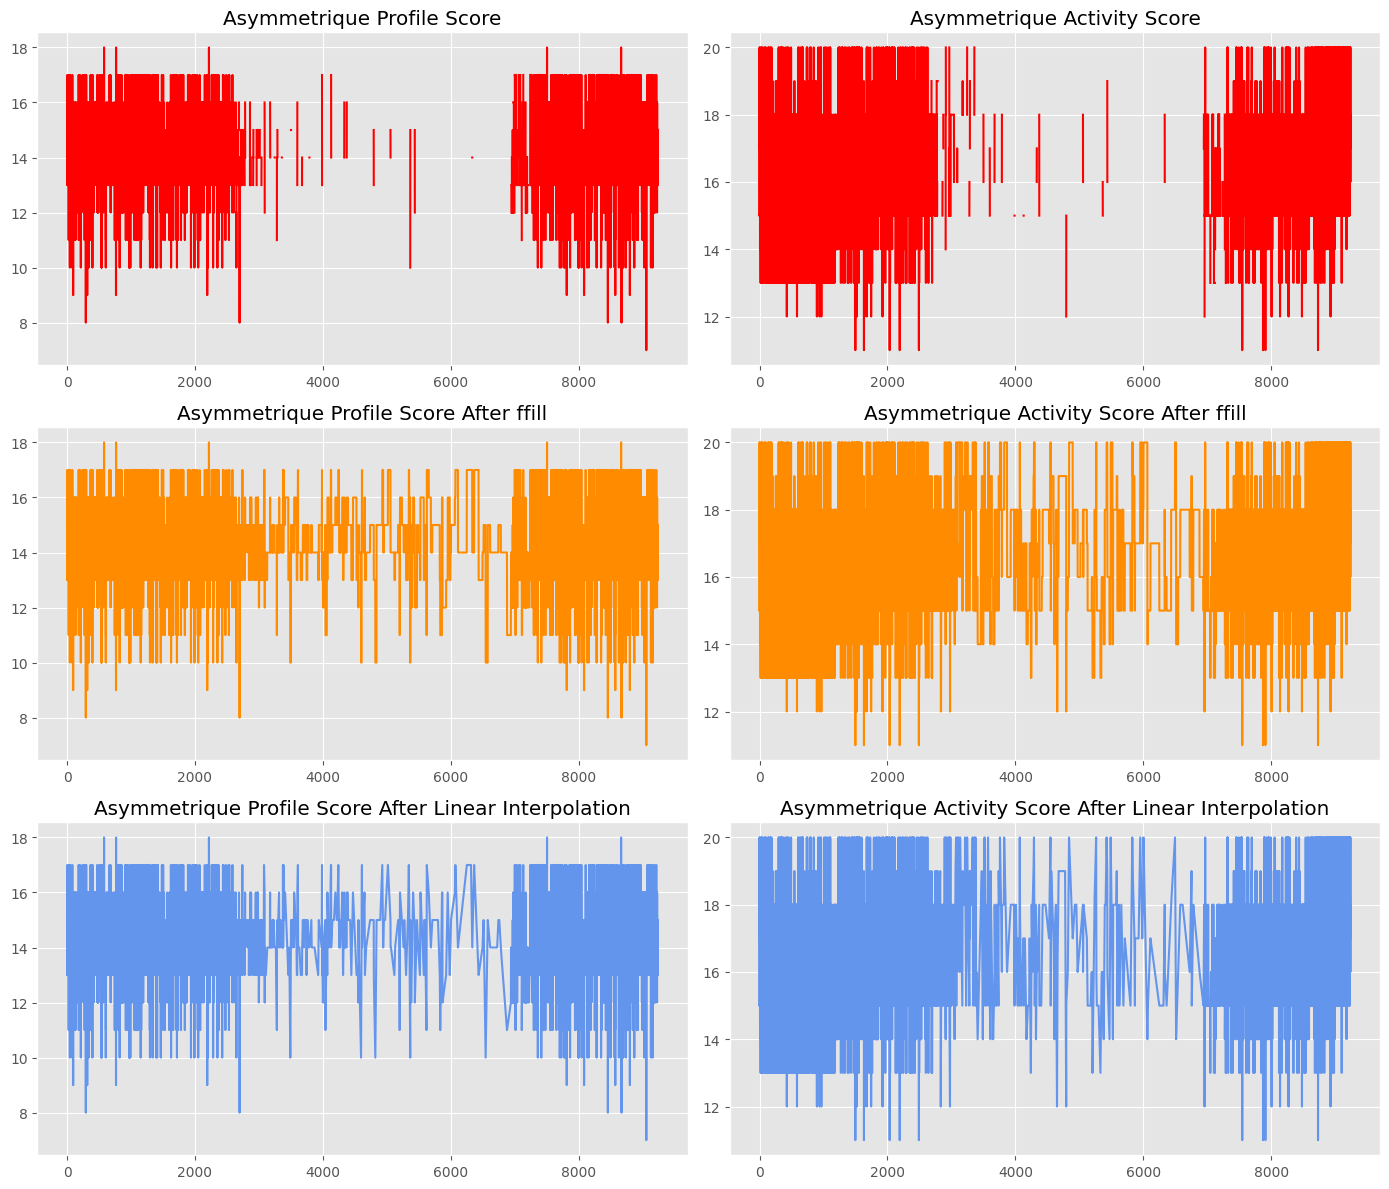

In [14]:
plt.figure(figsize=(14,12))
plt.subplot(321)
plt.title("Asymmetrique Profile Score")
plt.plot(num_df.iloc[:, 5], color = 'r')
plt.subplot(322)
plt.title("Asymmetrique Activity Score")
plt.plot(num_df.iloc[:, 6], color = 'r')
plt.subplot(323)
plt.title("Asymmetrique Profile Score After ffill")
plt.plot(num_df.iloc[:, 5].fillna(method = 'ffill'), color = 'darkorange')
plt.subplot(324)
plt.title("Asymmetrique Activity Score After ffill")
plt.plot(num_df.iloc[:, 6].fillna(method = 'ffill'), color = 'darkorange')
plt.subplot(325)
plt.title("Asymmetrique Profile Score After Linear Interpolation")
plt.plot(num_df.iloc[:, 5].interpolate(), color = 'cornflowerblue')
plt.subplot(326)
plt.title("Asymmetrique Activity Score After Linear Interpolation")
plt.plot(num_df.iloc[:, 6].interpolate(), color = 'cornflowerblue')
plt.tight_layout()

As we can see here there are lot of null values present so if we try to impute or interpolate the data will not be an ideal way in case if there are many null values available in your data. It's better to exclude that column to avoid randomness & bias in our model.

In [15]:
se_median = SimpleImputer(missing_values = np.nan, strategy='median')

In [16]:
num_df[['TotalVisits', 'Page Views Per Visit']] = se_median.fit_transform(num_df[['TotalVisits', 'Page Views Per Visit']])

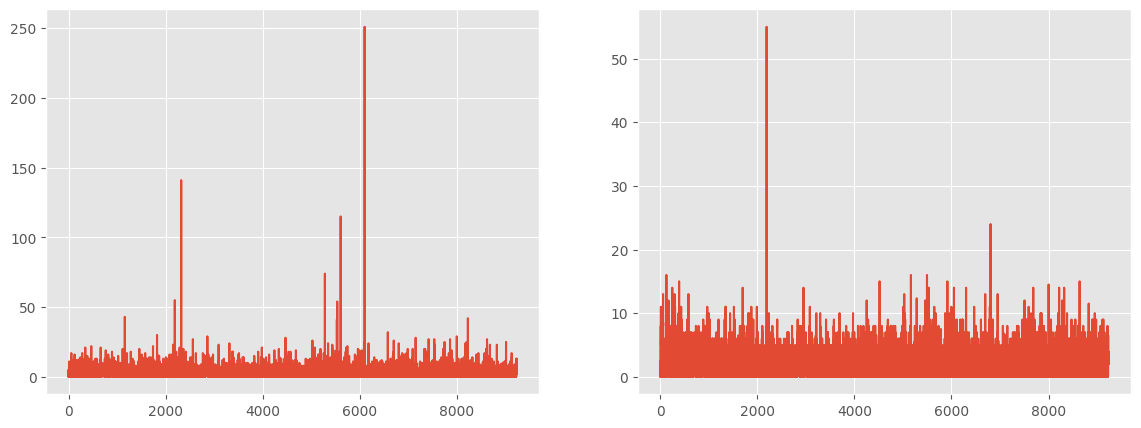

In [17]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(num_df['TotalVisits'])
plt.subplot(122)
plt.plot(num_df['Page Views Per Visit'])

In [18]:
num_df.isnull().sum()

Lead Number                       0
Converted                         0
TotalVisits                       0
Total Time Spent on Website       0
Page Views Per Visit              0
Asymmetrique Activity Score    4218
Asymmetrique Profile Score     4218
dtype: int64

In [19]:
num_df = num_df.drop(['Asymmetrique Activity Score', 'Asymmetrique Profile Score'], axis = 1)

In [20]:
#final data columns for numerical values which we are going to use for our analysis
num_df.isnull().sum()

Lead Number                    0
Converted                      0
TotalVisits                    0
Total Time Spent on Website    0
Page Views Per Visit           0
dtype: int64

### Categorical Data Feature Engineering + (Analysis)

In [21]:
(cat_df.isnull().sum()/cat_df.shape[0]*100).sort_values(ascending = False)

Lead Quality                                     51.590909
Asymmetrique Activity Index                      45.649351
Asymmetrique Profile Index                       45.649351
Tags                                             36.287879
Lead Profile                                     29.318182
What matters most to you in choosing a course    29.318182
What is your current occupation                  29.112554
Country                                          26.634199
How did you hear about X Education               23.885281
Specialization                                   15.562771
City                                             15.367965
Last Activity                                     1.114719
Lead Source                                       0.389610
I agree to pay the amount through cheque          0.000000
A free copy of Mastering The Interview            0.000000
Get updates on DM Content                         0.000000
Update me on Supply Chain Content                 0.0000

In [22]:
cat_null_cols = (cat_df.isnull().sum()/cat_df.shape[0]*100).sort_values(ascending = False)[:13].keys()

In [23]:
#creating a function which will iterate each value and check for the data type and returning if there as any int ot float values present 

def check_str(data, col):
    
    for i in data[col]: 
        if isinstance(i, str):
            continue
        else:
            print("Alert: Float/Int Values Found in Categorical Column..!!!")
            break

In [24]:
check_str(cat_df[cat_null_cols], 'Lead Quality')

Alert: Float/Int Values Found in Categorical Column..!!!


In [25]:
check_str(cat_df[cat_null_cols].fillna(value = str(np.nan)), 'Lead Quality')

In [26]:
cat_df[cat_null_cols].isnull().sum()

Lead Quality                                     4767
Asymmetrique Activity Index                      4218
Asymmetrique Profile Index                       4218
Tags                                             3353
Lead Profile                                     2709
What matters most to you in choosing a course    2709
What is your current occupation                  2690
Country                                          2461
How did you hear about X Education               2207
Specialization                                   1438
City                                             1420
Last Activity                                     103
Lead Source                                        36
dtype: int64

In [27]:
new_cat_df = cat_df[cat_null_cols]

In [28]:
new_cat_df.isnull().sum()/new_cat_df.shape[0]*100

Lead Quality                                     51.590909
Asymmetrique Activity Index                      45.649351
Asymmetrique Profile Index                       45.649351
Tags                                             36.287879
Lead Profile                                     29.318182
What matters most to you in choosing a course    29.318182
What is your current occupation                  29.112554
Country                                          26.634199
How did you hear about X Education               23.885281
Specialization                                   15.562771
City                                             15.367965
Last Activity                                     1.114719
Lead Source                                       0.389610
dtype: float64

<AxesSubplot:title={'center':'After Imputing with Most Frequent Value'}, xlabel='Lead Quality', ylabel='count'>

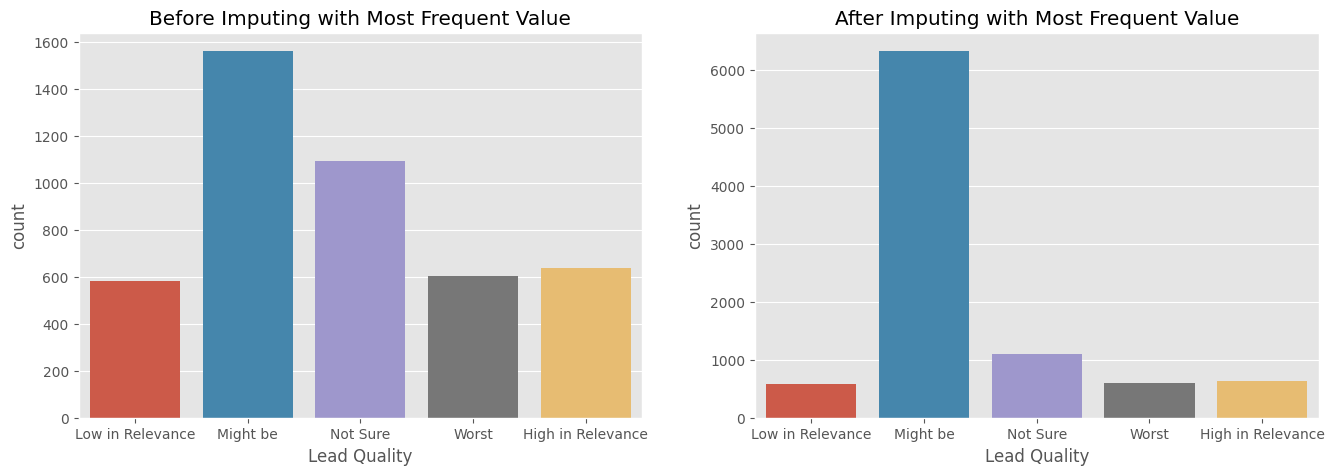

In [29]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.title("Before Imputing with Most Frequent Value")
sns.countplot(data = new_cat_df, x = 'Lead Quality')
plt.subplot(122)
plt.title("After Imputing with Most Frequent Value")
sns.countplot(data = new_cat_df.fillna(value = new_cat_df['Lead Quality'].mode()[0]), x = 'Lead Quality')

As you can see in our **'Lead Quality'** case if we try to impute **'NaN'** values with most frequent value then it will going to create an imbalance class with our column data which we definitely not want so we have to find some other way to tackle this situation of missing values.

In [30]:
new_cat_df.head()

Lead Quality Asymmetrique Activity Index Asymmetrique Profile Index  \
0  Low in Relevance                   02.Medium                  02.Medium   
1               NaN                   02.Medium                  02.Medium   
2          Might be                   02.Medium                    01.High   
3          Not Sure                   02.Medium                    01.High   
4          Might be                   02.Medium                    01.High   

                                  Tags    Lead Profile  \
0          Interested in other courses          Select   
1                              Ringing          Select   
2  Will revert after reading the email  Potential Lead   
3                              Ringing          Select   
4  Will revert after reading the email          Select   

  What matters most to you in choosing a course  \
0                       Better Career Prospects   
1                       Better Career Prospects   
2                       Better Career Prospects   
3                       Better Career Prospects   
4                       Better Career Prospects   

  What is your current occupation Country How did you hear about X Education  \
0                      Unemployed     NaN                             Select   
1                      Unemployed   India                             Select   
2                         Student   India                             Select   
3                      Unemployed   India                      Word Of Mouth   
4                      Unemployed   India                              Other   

            Specialization    City            Last Activity     Lead Source  
0                   Select  Select  Page Visited on Website      Olark Chat  
1                   Select  Select             Email Opened  Organic Search  
2  Business Administration  Mumbai             Email Opened  Direct Traffic  
3    Media and Advertising  Mumbai              Unreachable  Direct Traffic  
4                   Select  Mumbai        Converted to Lead          Google

Let's try to understand why there are Null Values Present into our data so based on that we will be able to identify which columns we can negate from our data and which columns we can keep for the imputation process.

In [31]:
new_cat_df.isnull().sum()

Lead Quality                                     4767
Asymmetrique Activity Index                      4218
Asymmetrique Profile Index                       4218
Tags                                             3353
Lead Profile                                     2709
What matters most to you in choosing a course    2709
What is your current occupation                  2690
Country                                          2461
How did you hear about X Education               2207
Specialization                                   1438
City                                             1420
Last Activity                                     103
Lead Source                                        36
dtype: int64

In [32]:
cat_df[(cat_df['Lead Source'].isnull())][['Lead Origin', 'Lead Source', 'Last Activity', 'City', 'Specialization', 'Country', 'Tags']]

Lead Origin Lead Source  Last Activity  \
836             Lead Add Form         NaN  Email Bounced   
1569            Lead Add Form         NaN       SMS Sent   
1746            Lead Add Form         NaN       SMS Sent   
2020            Lead Add Form         NaN       SMS Sent   
2025            Lead Add Form         NaN       SMS Sent   
2152            Lead Add Form         NaN       SMS Sent   
2346            Lead Add Form         NaN       SMS Sent   
2544              Lead Import         NaN   Email Opened   
2601           Quick Add Form         NaN  Email Bounced   
2676            Lead Add Form         NaN       SMS Sent   
3028            Lead Add Form         NaN       SMS Sent   
3266  Landing Page Submission         NaN       SMS Sent   
3268            Lead Add Form         NaN       SMS Sent   
3928            Lead Add Form         NaN  Email Bounced   
3945            Lead Add Form         NaN       SMS Sent   
4406            Lead Add Form         NaN       SMS Sent   
4409            Lead Add Form         NaN   Email Opened   
4605            Lead Add Form         NaN  Email Bounced   
4653            Lead Add Form         NaN       SMS Sent   
4804            Lead Add Form         NaN   Email Opened   
4831            Lead Add Form         NaN       SMS Sent   
4843            Lead Add Form         NaN       SMS Sent   
5253            Lead Add Form         NaN       SMS Sent   
5621            Lead Add Form         NaN       SMS Sent   
5840            Lead Add Form         NaN            NaN   
5960            Lead Add Form         NaN       SMS Sent   
6124            Lead Add Form         NaN       SMS Sent   
7302            Lead Add Form         NaN  Email Bounced   
7306            Lead Add Form         NaN       SMS Sent   
7525            Lead Add Form         NaN   Unsubscribed   
7847            Lead Add Form         NaN            NaN   
8092            Lead Add Form         NaN   Email Opened   
8118            Lead Add Form         NaN       SMS Sent   
8276            Lead Add Form         NaN   Email Opened   
8490            Lead Add Form         NaN       SMS Sent   
9160            Lead Add Form         NaN   Unsubscribed   

                             City             Specialization Country  \
836                        Select                     Select     NaN   
1569                       Select                     Select     NaN   
1746                       Select                     Select     NaN   
2020                       Select                     Select     NaN   
2025                       Select                     Select     NaN   
2152                       Select                     Select     NaN   
2346                       Select                     Select     NaN   
2544                       Select                     Select     NaN   
2601           Other Metro Cities                 E-COMMERCE     NaN   
2676  Other Cities of Maharashtra  Human Resource Management     NaN   
3028                       Select      Operations Management     NaN   
3266                       Mumbai         Finance Management   India   
3268                       Select                     Select     NaN   
3928                       Select                     Select     NaN   
3945                       Select                     Select     NaN   
4406                       Select                     Select     NaN   
4409                       Select                     Select     NaN   
4605                       Select                     Select     NaN   
4653                       Select                     Select     NaN   
4804                       Select                     Select     NaN   
4831                       Select                     Select     NaN   
4843                       Select                     Select     NaN   
5253                       Select                     Select     NaN   
5621            Thane & Outskirts         Finance Management     NaN 

So based on my understanding what I am able to conclude while inspecting the reason for Null Values in **'Lead Source'** is that the form fields which are available to the users are not marked mandatory that's why they're coming as null.

The Lead Source which are coming as Null are those who came from the **'Lead Add Form', 'Quick Add Form' & 'Landing Page Submission'**. Also, if we take a look at the associated **'Tags'** those give us bit of an idea that the person might not be interested or busy to attend or revert to any communication.

In [33]:
(cat_df[(cat_df['Last Activity'].isnull())][['Lead Origin', 'Lead Source', 'Last Activity', 'City', 'Specialization', 'Country', 'Tags']]).head(40)

Lead Origin       Lead Source Last Activity  \
77    Lead Add Form  Welingak Website           NaN   
79    Lead Add Form         Reference           NaN   
81    Lead Add Form  Welingak Website           NaN   
88    Lead Add Form         Reference           NaN   
120   Lead Add Form         Reference           NaN   
133   Lead Add Form         Reference           NaN   
134   Lead Add Form  Welingak Website           NaN   
177   Lead Add Form  Welingak Website           NaN   
179   Lead Add Form  Welingak Website           NaN   
180   Lead Add Form  Welingak Website           NaN   
212   Lead Add Form         Reference           NaN   
267   Lead Add Form         Reference           NaN   
269   Lead Add Form         Reference           NaN   
299   Lead Add Form         Reference           NaN   
348   Lead Add Form         Reference           NaN   
364   Lead Add Form         Reference           NaN   
369   Lead Add Form         Reference           NaN   
470   Lead Add Form         Reference           NaN   
585     Lead Import          Facebook           NaN   
587     Lead Import          Facebook           NaN   
589     Lead Import          Facebook           NaN   
590     Lead Import          Facebook           NaN   
591     Lead Import          Facebook           NaN   
592     Lead Import          Facebook           NaN   
593     Lead Import          Facebook           NaN   
596     Lead Import          Facebook           NaN   
597     Lead Import          Facebook           NaN   
598     Lead Import          Facebook           NaN   
601     Lead Import          Facebook           NaN   
603     Lead Import          Facebook           NaN   
631   Lead Add Form         Reference           NaN   
949   Lead Add Form  Welingak Website           NaN   
994   Lead Add Form  Welingak Website           NaN   
1099  Lead Add Form         Reference           NaN   
1136    Lead Import          Facebook           NaN   
1137    Lead Import          Facebook           NaN   
1145    Lead Import          Facebook           NaN   
1249  Lead Add Form         Reference           NaN   
1258  Lead Add Form         Reference           NaN   
1393  Lead Add Form  Welingak Website           NaN   

                             City                     Specialization Country  \
77                         Select                             Select     NaN   
79              Thane & Outskirts             Hospitality Management     NaN   
81                         Select                             Select     NaN   
88                         Mumbai          Human Resource Management     NaN   
120                  Other Cities               Marketing Management     NaN   
133                        Select               Marketing Management     NaN   
134                        Select                             Select     NaN   
177                        Mumbai                             Select     NaN   
179                        Select                             Select     NaN   
180                        Select                             Select     NaN   
212                  Other Cities               Marketing Management     NaN   
267                        Select                             Select     NaN   
269   Other Cities of Maharashtra              Operations Management     NaN   
299                        Mumbai          Human Resource Management     NaN   
348                        Mumbai              Media and Advertising     NaN   
364                        Mumbai              Healthcare Management     NaN   
369                        Mumbai            Supply Chain Management     NaN   
470                        Select                 Finance Management     NaN   
585   Other Cities of Maharashtra                             Select     NaN   
587                        Mumbai                             Select     NaN   
589                        Mumbai                             Select    

Here what I can see is that the person who filled the form from either these three sources that is **'Welingak Website', 'Reference', 'Facebook'** no activity has been registered for these users.

*But Why......????*

Maybe the person who are incharge can answer this question or maybe they are most likely to be converted also if we take a look at some of the tags cells, the lead from these sources are closed and maybe converted for the next lead stage.

In [34]:
(cat_df[(cat_df['Lead Quality'].isnull())][['Lead Quality', 'Lead Origin', 'Lead Source', 'Last Activity', 'City', 'Specialization', 'Country', 'Tags', 'Lead Profile']]).head(10)

Lead Quality              Lead Origin     Lead Source  \
1           NaN                      API  Organic Search   
5           NaN                      API      Olark Chat   
7           NaN                      API      Olark Chat   
8           NaN  Landing Page Submission  Direct Traffic   
9           NaN                      API          Google   
11          NaN  Landing Page Submission  Direct Traffic   
13          NaN  Landing Page Submission  Organic Search   
14          NaN  Landing Page Submission  Direct Traffic   
16          NaN                      API      Olark Chat   
18          NaN  Landing Page Submission          Google   

              Last Activity               City             Specialization  \
1              Email Opened             Select                     Select   
5   Olark Chat Conversation                NaN                        NaN   
7   Olark Chat Conversation                NaN                        NaN   
8              Email Opened  Thane & Outskirts     IT Projects Management   
9              Email Opened             Mumbai         Finance Management   
11  Page Visited on Website  Thane & Outskirts  Human Resource Management   
13             Email Opened  Thane & Outskirts    Business Administration   
14            Email Bounced             Select    Business Administration   
16  Olark Chat Conversation                NaN                        NaN   
18  Page Visited on Website             Mumbai       Marketing Management   

   Country          Tags Lead Profile  
1    India       Ringing       Select  
5      NaN           NaN          NaN  
7      NaN           NaN          NaN  
8    India           NaN          NaN  
9    India           NaN          NaN  
11   India  Lost to EINS       Select  
13   India       Ringing       Select  
14  Russia           NaN       Select  
16     NaN           NaN          NaN  
18   India           NaN       Select

If we take a look at the **'Lead Quality'** we can see lot of **NaN** values. The reason which I think is because of the other column information are not presented so that's why the CRM not able to judget or assign the **"Lead Quality"**. Before going to any of the conclusion, let's first check the data where we don't have the null values.

In [35]:
(cat_df[(~cat_df['Lead Quality'].isnull())][['Lead Quality', 'Lead Origin', 'Lead Source', 'Last Activity', 'City', 'Specialization', 'Country', 'Tags', 'Lead Profile']]).head(10)

Lead Quality              Lead Origin     Lead Source  \
0   Low in Relevance                      API      Olark Chat   
2           Might be  Landing Page Submission  Direct Traffic   
3           Not Sure  Landing Page Submission  Direct Traffic   
4           Might be  Landing Page Submission          Google   
6   Low in Relevance  Landing Page Submission          Google   
10          Might be  Landing Page Submission  Organic Search   
12          Might be                      API  Organic Search   
15          Might be                      API  Organic Search   
17          Might be                      API  Referral Sites   
19             Worst                      API  Organic Search   

              Last Activity                City           Specialization  \
0   Page Visited on Website              Select                   Select   
2              Email Opened              Mumbai  Business Administration   
3               Unreachable              Mumbai    Media and Advertising   
4         Converted to Lead              Mumbai                   Select   
6              Email Opened              Mumbai  Supply Chain Management   
10             Email Opened  Other Metro Cities       Travel and Tourism   
12             Email Opened              Select     Marketing Management   
15             Email Opened              Select                   Select   
17       Email Link Clicked              Select                   Select   
19  Page Visited on Website              Select                   Select   

   Country                                 Tags    Lead Profile  
0      NaN          Interested in other courses          Select  
2    India  Will revert after reading the email  Potential Lead  
3    India                              Ringing          Select  
4    India  Will revert after reading the email          Select  
6    India  Will revert after reading the email  Potential Lead  
10   India  Will revert after reading the email          Select  
12   India  Will revert after reading the email  Potential Lead  
15   India  Will revert after reading the email          Select  
17   India          Interested in other courses          Select  
19   India          Interested in other courses          Select

As you can see here we have lot of information present in other columns so that's why the **'Lead Quality'** has assigned to each prospect, this is what I think after inspecting the data.

In [36]:
new_cat_df.isnull().sum()/new_cat_df.shape[0]

Lead Quality                                     0.515909
Asymmetrique Activity Index                      0.456494
Asymmetrique Profile Index                       0.456494
Tags                                             0.362879
Lead Profile                                     0.293182
What matters most to you in choosing a course    0.293182
What is your current occupation                  0.291126
Country                                          0.266342
How did you hear about X Education               0.238853
Specialization                                   0.155628
City                                             0.153680
Last Activity                                    0.011147
Lead Source                                      0.003896
dtype: float64

Let's exclude those columns where we have Null Values more than 40% as imputing those values will not going to be good strategy but if we try to include those columns there may be a chance of bias & within class imbalance will gets added to our model so for now what we can do is to exclude those columns only and try to impute those columns where we have null values below the threshold which we are consider for selecting those columns for imputation.

In [37]:
temp_cat_df = new_cat_df.drop(["Lead Quality", "Asymmetrique Profile Index", "Asymmetrique Activity Index"], axis = 1)

In [38]:
(temp_cat_df.isnull().sum()/temp_cat_df.shape[0])

Tags                                             0.362879
Lead Profile                                     0.293182
What matters most to you in choosing a course    0.293182
What is your current occupation                  0.291126
Country                                          0.266342
How did you hear about X Education               0.238853
Specialization                                   0.155628
City                                             0.153680
Last Activity                                    0.011147
Lead Source                                      0.003896
dtype: float64

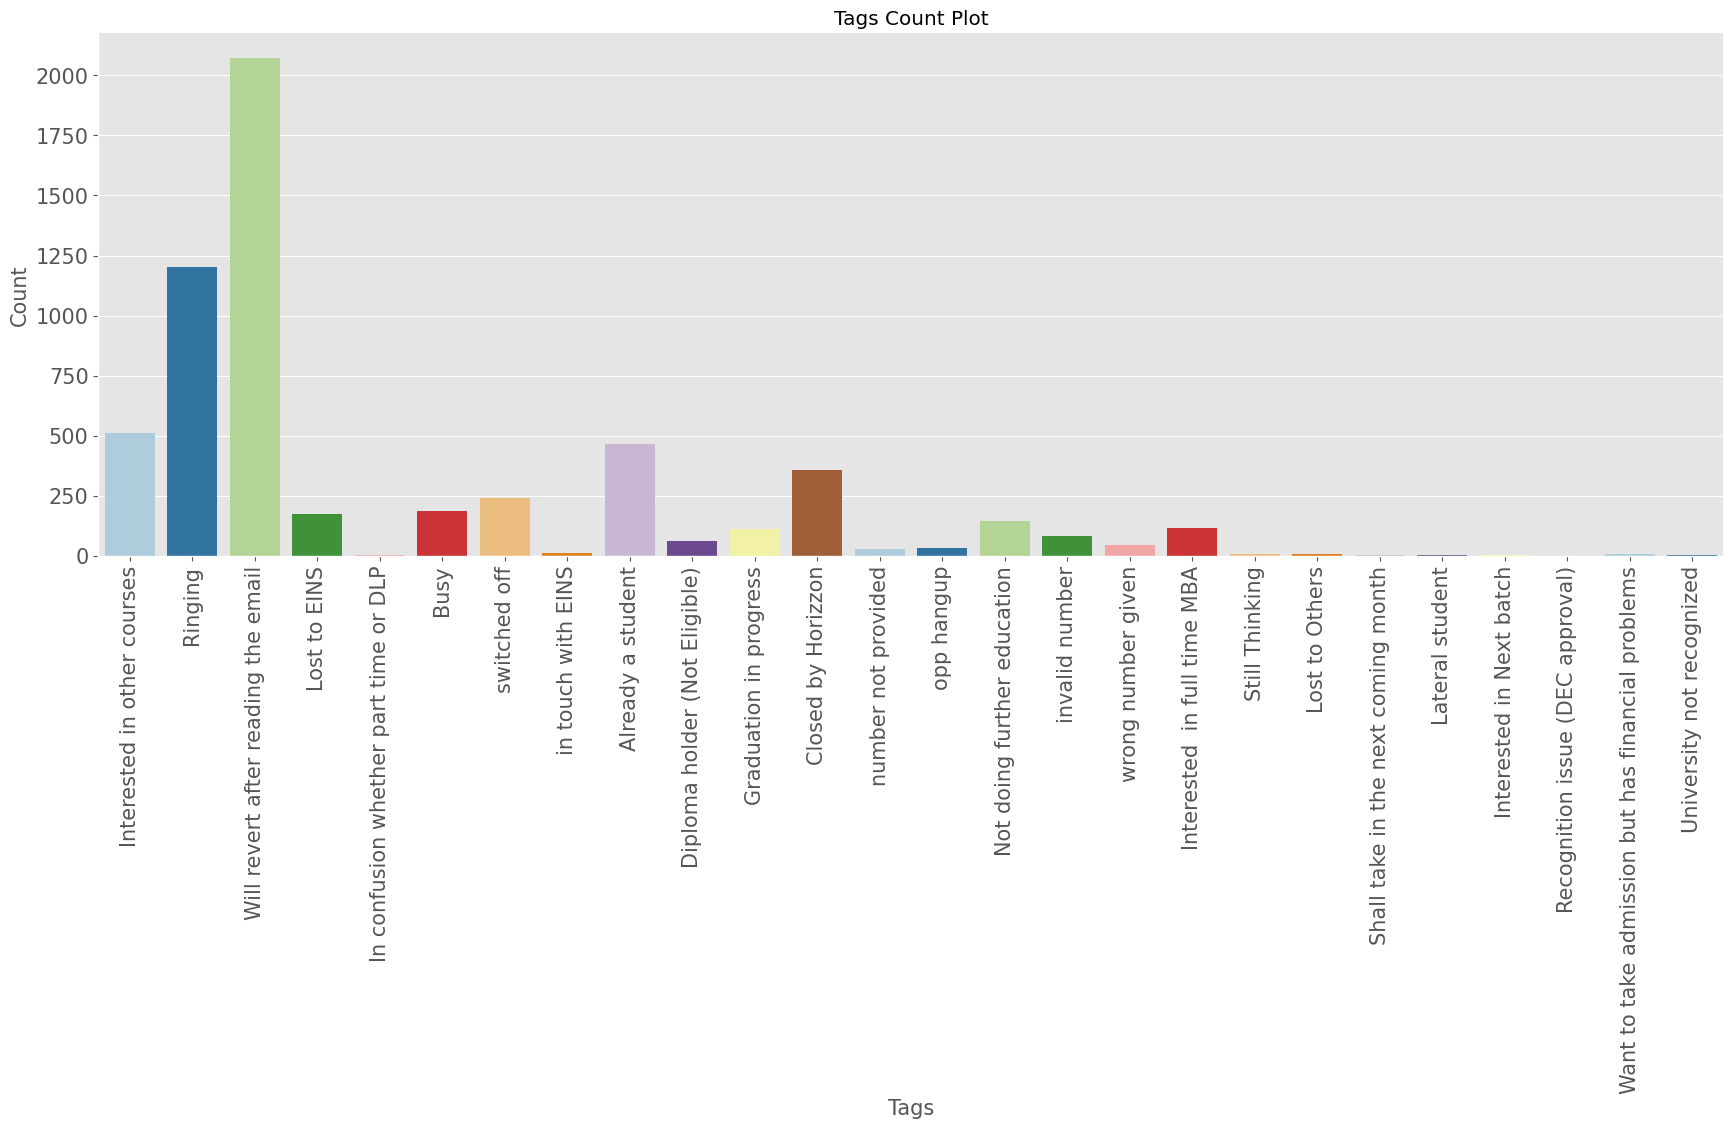

In [39]:
sns.catplot(data = temp_cat_df, x = 'Tags', kind = 'count', palette = 'Paired', aspect = 3, height=6).set(title = 'Tags Count Plot')
plt.xticks(rotation = 'vertical')
plt.tick_params(labelsize=15)
plt.xlabel("Tags", size = 15)
plt.ylabel("Count", size = 15)
plt.show()

If we take a look at the **Null** values that are present in the **"Tags"** column are 36% but apart from that we can see here is that most people have reply with **"Will revert after reading the email"** & few of them did not picked up the call and their call went unanswered.

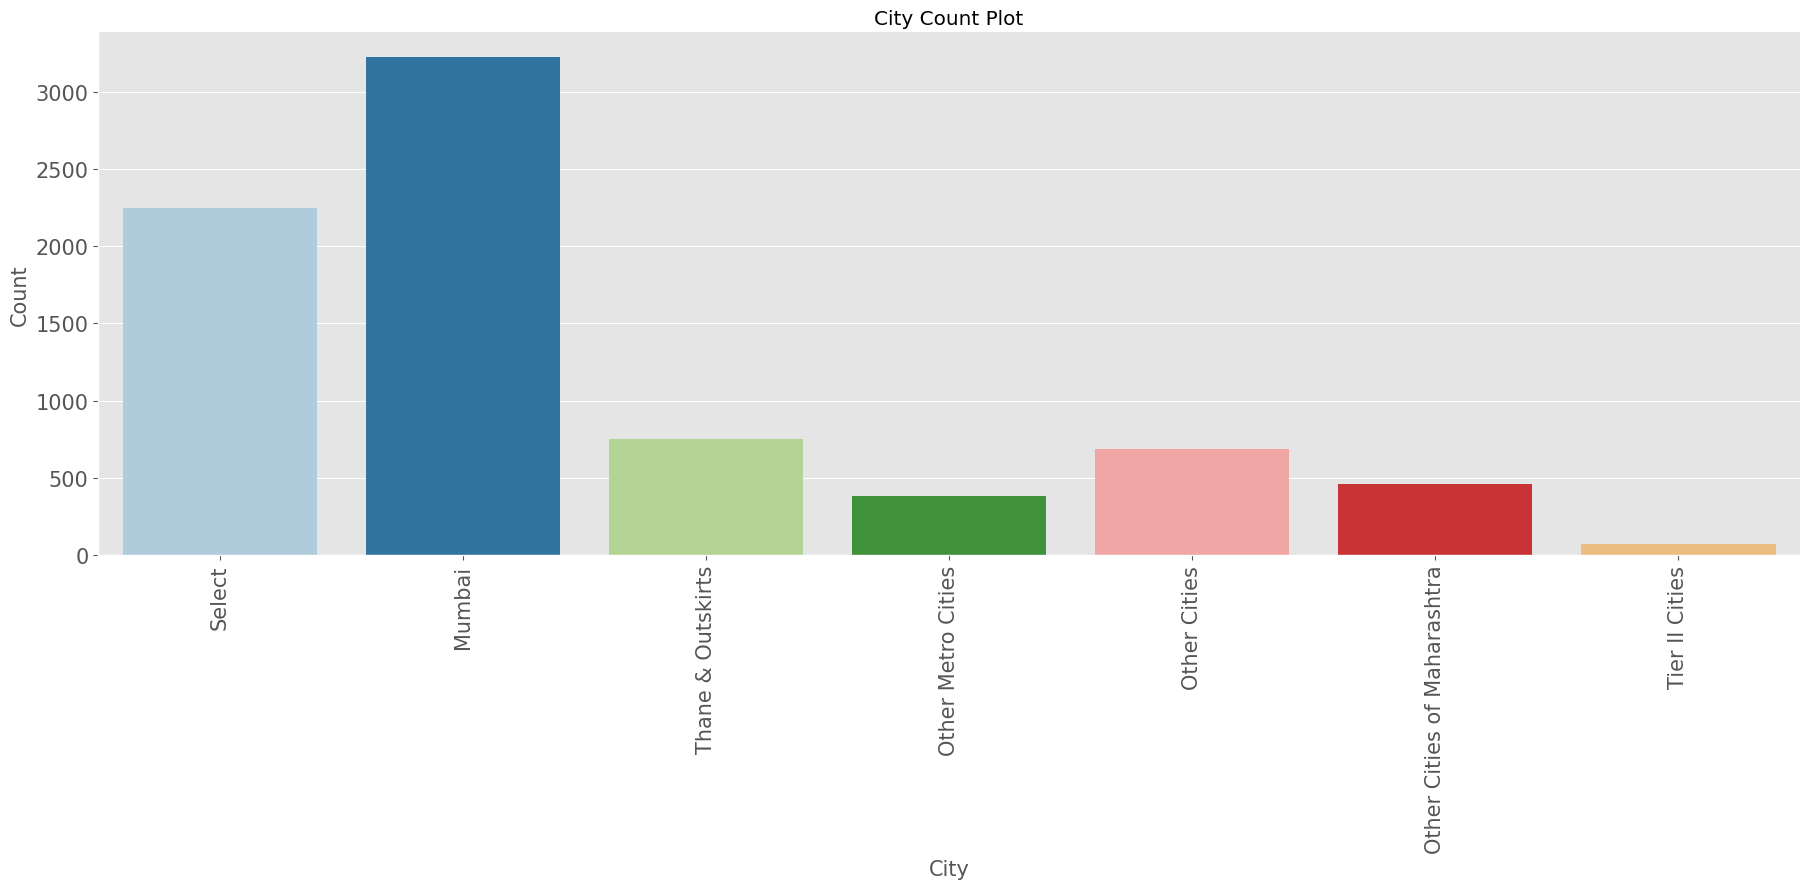

In [40]:
sns.catplot(data = temp_cat_df, x = 'City', kind = 'count', palette = 'Paired', aspect = 3, height=6).set(title = 'City Count Plot')
plt.xticks(rotation = 'vertical')
plt.tick_params(labelsize=15)
plt.xlabel("City", size = 15)
plt.ylabel("Count", size = 15)
plt.show()

We have close to ~15% Null values in our city columns but most of the users who have filled the lead form are from **"Mumbai"** but most people have not selected their city.

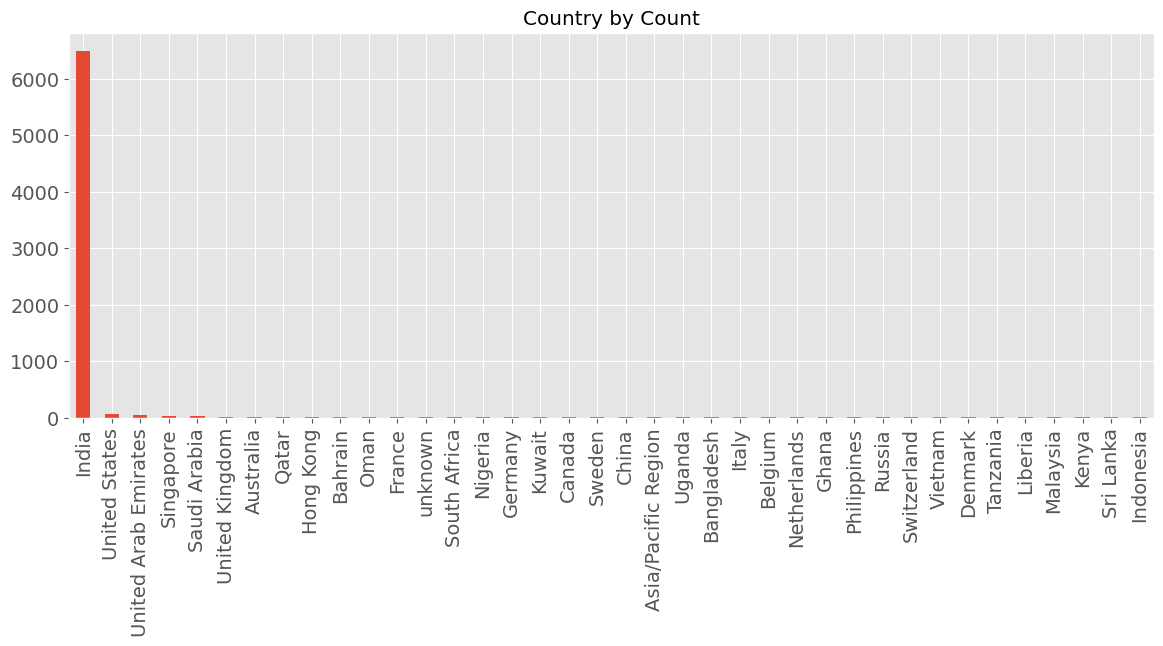

In [41]:
plt.figure(figsize=(14,5))
temp_cat_df.Country.value_counts().plot(kind = 'bar').set(title = "Country by Count")
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

Based on the above count plot we can say that mostly audience are from **"India"**.

In [42]:
px.pie(data_frame = temp_cat_df, names = 'Specialization', title = 'Specialization Distribution')

When it comes to Specialization, we have ~16% Null values and 21% people have not selected the values. But apart from that **Finance Management, HR & Marketing Management** are the most popular specialization among the users.

In [43]:
px.pie(data_frame = temp_cat_df, names = 'Lead Profile', title = 'Lead Profile Distribution')

When it comes to Lead Profile Distribution, we have 29.3% Null Values with ~45% have not selected the values.

In [44]:
px.histogram(data_frame = temp_cat_df, x = 'Lead Source', title = 'Lead Source Distribution')

In our data **"Google"** is the most popular lead source destination followed by **"Direct Traffic", "Olark Chat" and "Organic Search"**. One thing to note here is that we have not included the null values.

In [45]:
px.histogram(data_frame = temp_cat_df, x = 'Last Activity', title = 'Last Activity Distribution')

In [46]:
px.pie(temp_cat_df, 'What matters most to you in choosing a course', title = 'What matters most to you in choosing a course')

The one most important point to note here is that the prospects who have filled the lead form for course inquiry are looking for  **"Better Career Prospects"** which is obvious that's what we human are. We always seek to look for better opportunity.

In [47]:
px.pie(temp_cat_df, 'What is your current occupation', title = 'What is your current occupation')

One more interesting point here is that the users who have filled this form are **"Unemployed"**. Apart from that **"Working Professional"** are also looking to upskill themselves for better career opportunities.

In [48]:
px.pie(data_frame = temp_cat_df, names = 'How did you hear about X Education', title = 'How did you hear about X Education')

When it comes to user acquistion medium, if we exclude the not **"selected" and "null"**  values, the **"Online Search"** is the most popular user acquisiton medium followed by **"Word of Mouth"**. 

So now we have a fair understanding of our categorical data and we also know some of the reason behind the null values which is more important as a analyst before taking any preprocessing or feature engineering step. Now we are going to impute our categorical data and then we are going to club our numerical and categorical data for final EDA process.

### Categorical Data Feature Engineering - II (Imputation + EDA)

In [49]:
idx = cat_df.isnull().sum()[cat_df.isnull().sum() < 1].keys()

In [50]:
temp_cat_df = pd.concat([temp_cat_df, cat_df[idx]], axis = 1)

In [51]:
#lets once again take a look at the null values

temp_cat_df.isnull().sum()

Tags                                             3353
Lead Profile                                     2709
What matters most to you in choosing a course    2709
What is your current occupation                  2690
Country                                          2461
How did you hear about X Education               2207
Specialization                                   1438
City                                             1420
Last Activity                                     103
Lead Source                                        36
Prospect ID                                         0
Lead Origin                                         0
Do Not Email                                        0
Do Not Call                                         0
Search                                              0
Magazine                                            0
Newspaper Article                                   0
X Education Forums                                  0
Newspaper                   

In [52]:
#Let's first impute the Lead Source
temp_cat_df['Lead Source'].value_counts()

Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Press_Release           2
Social Media            2
Live Chat               2
youtubechannel          1
testone                 1
Pay per Click Ads       1
welearnblog_Home        1
WeLearn                 1
blog                    1
NC_EDM                  1
Name: Lead Source, dtype: int64

As you can see here, we have same lead source named as 2 different which we can combine. So let's first combine them both.

In [53]:
temp_cat_df['Lead Source'].replace(to_replace = 'google', value = 'Google', inplace = True)

In [54]:
temp_cat_df['Lead Source'].value_counts()

Google               2873
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
Click2call              4
Social Media            2
Live Chat               2
Press_Release           2
Pay per Click Ads       1
blog                    1
WeLearn                 1
welearnblog_Home        1
youtubechannel          1
testone                 1
NC_EDM                  1
Name: Lead Source, dtype: int64

See, it seems much fine now. Now for the 36 values which are null, what we can do is we can introduce a new lead source named **"Others"**.

In [55]:
temp_cat_df['Lead Source'].replace(to_replace = np.nan, value = 'Others', inplace = True)

In [56]:
temp_cat_df['Lead Source'].value_counts()

Google               2873
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
Others                 36
bing                    6
Click2call              4
Press_Release           2
Social Media            2
Live Chat               2
youtubechannel          1
testone                 1
Pay per Click Ads       1
welearnblog_Home        1
WeLearn                 1
blog                    1
NC_EDM                  1
Name: Lead Source, dtype: int64

Now we are going to impute the "Last Activity" column but the imputation will going to be done on using the secondary column which is more correlated with our 'Last Activity' column which is 'Tags'. So based on tags we will going to impute the 'Last Activity' by using the most frequent item.

In [57]:
temp_cat_df[temp_cat_df['Last Activity'].isnull()]

Tags     Lead Profile  \
77                                    NaN           Select   
79    Will revert after reading the email   Potential Lead   
81                                    NaN           Select   
88                     Closed by Horizzon  Lateral Student   
120                    Closed by Horizzon   Potential Lead   
...                                   ...              ...   
8097         Interested  in full time MBA           Select   
8107                         Lost to EINS   Potential Lead   
8434                   Closed by Horizzon           Select   
9015                   Closed by Horizzon   Potential Lead   
9087                   Closed by Horizzon   Potential Lead   

     What matters most to you in choosing a course  \
77                         Better Career Prospects   
79                         Better Career Prospects   
81                         Better Career Prospects   
88                         Better Career Prospects   
120                        Better Career Prospects   
...                                            ...   
8097                       Better Career Prospects   
8107                       Better Career Prospects   
8434                       Better Career Prospects   
9015                       Better Career Prospects   
9087                       Better Career Prospects   

     What is your current occupation Country  \
77                        Unemployed     NaN   
79              Working Professional     NaN   
81                        Unemployed     NaN   
88                        Unemployed     NaN   
120             Working Professional     NaN   
...                              ...     ...   
8097                      Unemployed     NaN   
8107            Working Professional     NaN   
8434                      Unemployed     NaN   
9015            Working Professional     NaN   
9087                      Unemployed     NaN   

     How did you hear about X Education                     Specialization  \
77                               Select                             Select   
79                               Select             Hospitality Management   
81                               Select                             Select   
88                               Select          Human Resource Management   
120                              Select               Marketing Management   
...                                 ...                                ...   
8097                             Select               Marketing Management   
8107                             Select  Banking, Investment And Insurance   
8434                             Select                             Select   
9015                             Select            Supply Chain Management   
9087                             Select                             Select   

                   City Last Activity       Lead Source  ...  \
77               Select           NaN  Welingak Website  ...   
79    Thane & Outskirts           NaN         Reference  ...   
81               Select           NaN  Welingak Website  ...   
88               Mumbai           NaN         Reference  ...   
120        Other Cities           NaN         Reference  ...   
...                 ...           ...               ...  ...   
8097             Select           NaN         Reference  ...   
8107             Select           NaN         Reference  ...   
8434             Select           NaN         Reference  ...   
9015             Mumbai           NaN         Reference  ...   
9087             Select           NaN         Reference  ...   

     X Education Forums Newspaper Digital Advertisement  \
77                   No        No                    No   
79                   No        No                    No   
81                   No        No                    No   
88                   No        No                    No   
120                  No        No                    No   
...   

In [58]:
temp_cat_df[temp_cat_df['Last Activity'].isnull()]['Tags'].value_counts()

Closed by Horizzon                     47
Will revert after reading the email    26
Ringing                                12
Interested in other courses             4
Lost to EINS                            2
number not provided                     1
Busy                                    1
Interested  in full time MBA            1
Name: Tags, dtype: int64

Now let's find out corresponding most frequent item under the "Last Activity so that we can impute the missing values.

In [59]:
print(temp_cat_df[(temp_cat_df['Tags'] == 'Closed by Horizzon')]['Last Activity'].mode())
print(temp_cat_df[(temp_cat_df['Tags'] == 'Will revert after reading the email')]['Last Activity'].mode())
print(temp_cat_df[(temp_cat_df['Tags'] == 'Ringing')]['Last Activity'].mode())
print(temp_cat_df[(temp_cat_df['Tags'] == 'Interested in other courses')]['Last Activity'].mode())
print(temp_cat_df[(temp_cat_df['Tags'] == 'number not provided')]['Last Activity'].mode())
print(temp_cat_df[(temp_cat_df['Tags'] == 'Busy')]['Last Activity'].mode())
print(temp_cat_df[(temp_cat_df['Tags'] == 'Interested  in full time MBA')]['Last Activity'].mode())

0    Email Opened
Name: Last Activity, dtype: object
0    SMS Sent
Name: Last Activity, dtype: object
0    Email Opened
Name: Last Activity, dtype: object
0    Email Opened
Name: Last Activity, dtype: object
0    SMS Sent
Name: Last Activity, dtype: object
0    SMS Sent
Name: Last Activity, dtype: object
0    Email Opened
Name: Last Activity, dtype: object


In [60]:
temp_cat_df.loc[(temp_cat_df['Last Activity'].isnull()) & (temp_cat_df['Tags'] == 'Closed by Horizzon'), 'Last Activity'] = 'Email Opened'
temp_cat_df.loc[(temp_cat_df['Last Activity'].isnull()) & (temp_cat_df['Tags'] == 'Will revert after reading the email'), 'Last Activity'] = 'Email Opened'
temp_cat_df.loc[(temp_cat_df['Last Activity'].isnull()) & (temp_cat_df['Tags'] == 'Ringing'), 'Last Activity'] = 'SMS Sent'
temp_cat_df.loc[(temp_cat_df['Last Activity'].isnull()) & (temp_cat_df['Tags'] == 'Interested in other courses'), 'Last Activity'] = 'Email Opened'
temp_cat_df.loc[(temp_cat_df['Last Activity'].isnull()) & (temp_cat_df['Tags'] == 'Lost to EINS'), 'Last Activity'] = 'Email Opened'
temp_cat_df.loc[(temp_cat_df['Last Activity'].isnull()) & (temp_cat_df['Tags'] == 'number not provided'), 'Last Activity'] = 'SMS Sent'
temp_cat_df.loc[(temp_cat_df['Last Activity'].isnull()) & (temp_cat_df['Tags'] == 'Busy'), 'Last Activity'] = 'SMS Sent'
temp_cat_df.loc[(temp_cat_df['Last Activity'].isnull()) & (temp_cat_df['Tags'] == 'Interested  in full time MBA'), 'Last Activity'] = 'Email Opened'

In [61]:
temp_cat_df[temp_cat_df['Last Activity'].isnull()]

Tags Lead Profile What matters most to you in choosing a course  \
77    NaN       Select                       Better Career Prospects   
81    NaN       Select                       Better Career Prospects   
134   NaN       Select                       Better Career Prospects   
179   NaN       Select                       Better Career Prospects   
180   NaN       Select                       Better Career Prospects   
994   NaN       Select                       Better Career Prospects   
1393  NaN       Select                       Better Career Prospects   
2942  NaN       Select                       Better Career Prospects   
5840  NaN       Select                       Better Career Prospects   

     What is your current occupation Country  \
77                        Unemployed     NaN   
81                        Unemployed     NaN   
134                       Unemployed     NaN   
179                       Unemployed     NaN   
180                       Unemployed     NaN   
994                       Unemployed     NaN   
1393                      Unemployed     NaN   
2942                      Unemployed     NaN   
5840                      Unemployed     NaN   

     How did you hear about X Education Specialization    City Last Activity  \
77                               Select         Select  Select           NaN   
81                               Select         Select  Select           NaN   
134                              Select         Select  Select           NaN   
179                              Select         Select  Select           NaN   
180                              Select         Select  Select           NaN   
994                              Select         Select  Select           NaN   
1393                             Select         Select  Select           NaN   
2942                             Select         Select  Select           NaN   
5840                             Select         Select  Select           NaN   

           Lead Source  ... X Education Forums Newspaper  \
77    Welingak Website  ...                 No        No   
81    Welingak Website  ...                 No        No   
134   Welingak Website  ...                 No        No   
179   Welingak Website  ...                 No        No   
180   Welingak Website  ...                 No        No   
994   Welingak Website  ...                 No        No   
1393  Welingak Website  ...                 No        No   
2942         Reference  ...                 No        No   
5840            Others  ...                 No        No   

     Digital Advertisement Through Recommendations  \
77                      No                      No   
81                      No                      No   
134                     No                      No   
179                     No                      No   
180                     No                      No   
994                     No                      No   
1393                    No                      No   
2942                    No                      No   
5840                    No                      No   

     Receive More Updates About Our Courses Update me on Supply Chain Content  \
77                                       No                                No   
81                                       No                                No   
134                                      No                                No   
179                                      No                                No   
180                                      No                                No   
994                                      No                                No   
1393                                     No                                No   
2942                                     No                                No   
5840                                     No                                No   

     Get updates on DM Content I agree to pay the

In [62]:
(temp_cat_df[(temp_cat_df['What matters most to you in choosing a course'] == 'Better Career Prospects') & (temp_cat_df['What is your current occupation'] == 'Unemployed')]['Last Activity']).mode()

0    Email Opened
Name: Last Activity, dtype: object

In [63]:
temp_cat_df['Last Activity'].replace(to_replace = np.nan, value = 'Email Opened', inplace = True)

In [64]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]], column_titles = ['Before Manual Imputation', 'After Manual Imputation'], )

fig.add_trace(

    go.Pie(labels = cat_df['Last Activity']), row = 1, col = 1
)

fig.add_trace(

    go.Pie(labels = temp_cat_df['Last Activity']), row = 1, col = 2
)

fig.update_layout(title_text = 'Last Activity Imputation', showlegend=False)

In [65]:
temp_cat_df.isnull().sum()/temp_cat_df.shape[0]

Tags                                             0.362879
Lead Profile                                     0.293182
What matters most to you in choosing a course    0.293182
What is your current occupation                  0.291126
Country                                          0.266342
How did you hear about X Education               0.238853
Specialization                                   0.155628
City                                             0.153680
Last Activity                                    0.000000
Lead Source                                      0.000000
Prospect ID                                      0.000000
Lead Origin                                      0.000000
Do Not Email                                     0.000000
Do Not Call                                      0.000000
Search                                           0.000000
Magazine                                         0.000000
Newspaper Article                                0.000000
X Education Fo

In [66]:
cat_df_copy = temp_cat_df.copy()

In [67]:
cat_df_copy.drop("Country", axis = 1, inplace = True)

In [68]:
# we are creating a new variable for those values which are either 'Select' or 'NaN' for these 4 columns.
cat_df_copy['City'].replace(to_replace = ['Select', np.nan], value = 'Unspecified', inplace = True)
cat_df_copy['Specialization'].replace(to_replace = ['Select', np.nan], value = 'Unspecified', inplace = True)
cat_df_copy['Lead Profile'].replace(to_replace = ['Select', np.nan], value = 'Unspecified', inplace = True)
cat_df_copy['How did you hear about X Education'].replace(to_replace = ['Select', np.nan], value = 'Unspecified', inplace = True)

#imputing with most frequent item in a itemset
cat_df_copy["What matters most to you in choosing a course"].replace(to_replace = np.nan, value = 'Better Career Prospects', inplace = True)
cat_df_copy["What is your current occupation"].replace(to_replace = np.nan, value = 'Unemployed', inplace = True)

In [69]:
#imputing the frequent value in case of any null values present in our data
(cat_df_copy.isnull().sum()/cat_df_copy.shape[0]).sort_values(ascending = False)

Tags                                             0.362879
Lead Profile                                     0.000000
A free copy of Mastering The Interview           0.000000
I agree to pay the amount through cheque         0.000000
Get updates on DM Content                        0.000000
Update me on Supply Chain Content                0.000000
Receive More Updates About Our Courses           0.000000
Through Recommendations                          0.000000
Digital Advertisement                            0.000000
Newspaper                                        0.000000
X Education Forums                               0.000000
Newspaper Article                                0.000000
Magazine                                         0.000000
Search                                           0.000000
Do Not Call                                      0.000000
Do Not Email                                     0.000000
Lead Origin                                      0.000000
Prospect ID   

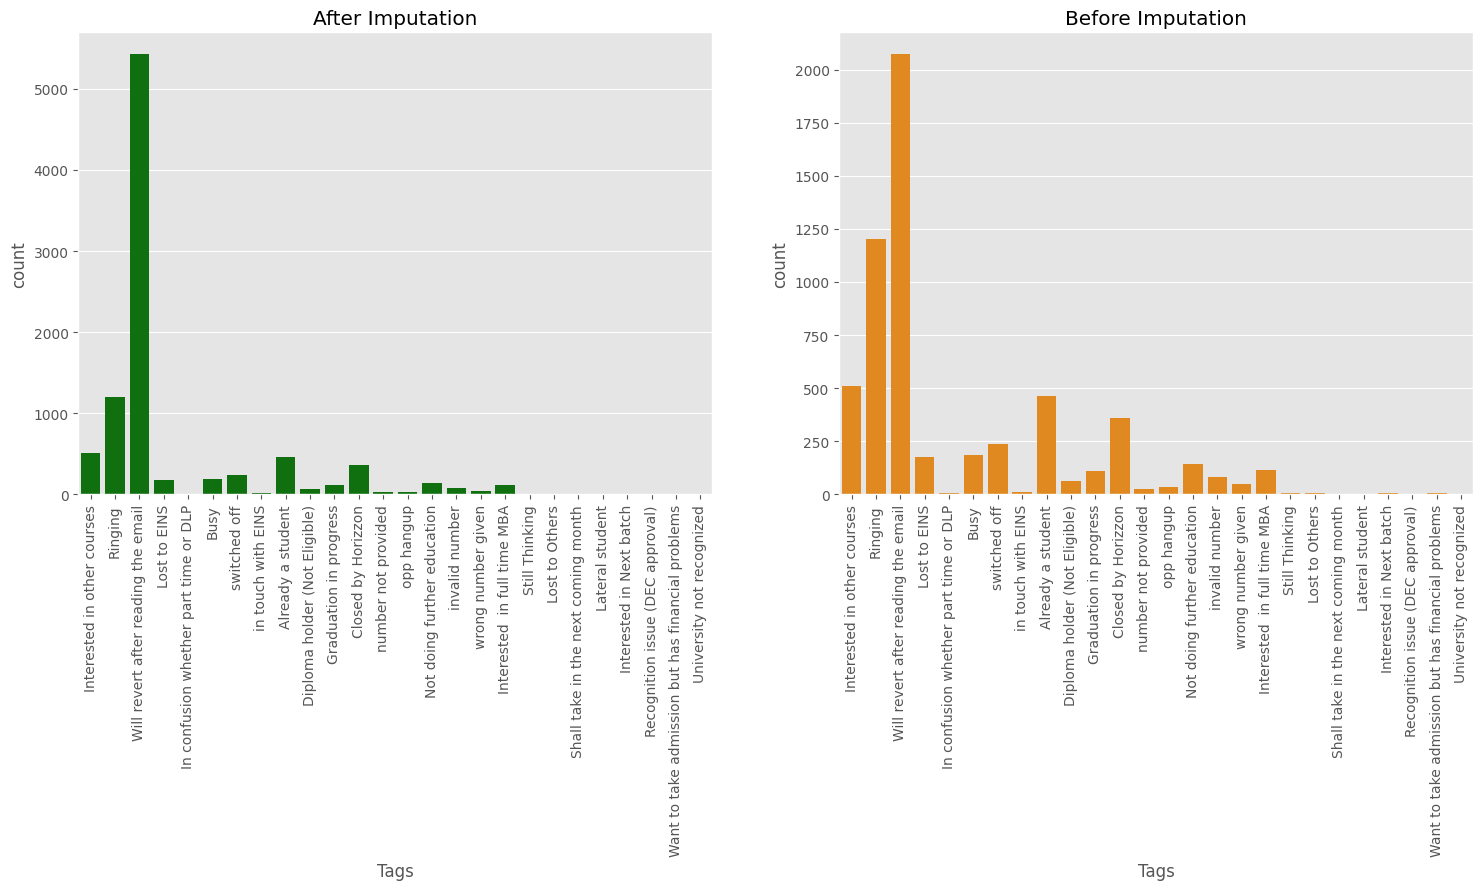

In [70]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.title("After Imputation")
sns.countplot(cat_df_copy['Tags'].fillna("Will revert after reading the email"), color = 'g')
plt.xticks(rotation = "vertical")
plt.subplot(122)
plt.title("Before Imputation")
sns.countplot(cat_df_copy['Tags'], color = 'darkorange')
plt.xticks(rotation = "vertical")
plt.show()

In [71]:
pd.set_option('display.max_columns', 500)

In [72]:
#dropping prospect id as we have lead number so these 2 will be the same for the identification
cat_df_copy.drop('Prospect ID', axis = 1, inplace = True)

In [73]:
encoder = OrdinalEncoder()

In [74]:
temp_df = cat_df_copy.copy()

In [75]:
temp_df['Tags'].replace(to_replace = np.nan, value = 'nan', inplace = True)

In [76]:
encode_df = pd.DataFrame(encoder.fit_transform(temp_df), columns = temp_df.columns)

In [77]:
encode_df.Tags.replace(to_replace = 22.0, value = np.nan, inplace = True)

In [78]:
check_str(encode_df, 'Tags')

Alert: Float/Int Values Found in Categorical Column..!!!


In [79]:
knn_imputer = KNN(k = 6)

In [80]:
impute_data = knn_imputer.fit_transform(encode_df)

Imputing row 1/9240 with 0 missing, elapsed time: 20.507
Imputing row 101/9240 with 0 missing, elapsed time: 20.511
Imputing row 201/9240 with 0 missing, elapsed time: 20.515
Imputing row 301/9240 with 1 missing, elapsed time: 20.519
Imputing row 401/9240 with 0 missing, elapsed time: 20.525
Imputing row 501/9240 with 0 missing, elapsed time: 20.529
Imputing row 601/9240 with 0 missing, elapsed time: 20.533
Imputing row 701/9240 with 0 missing, elapsed time: 20.539
Imputing row 801/9240 with 1 missing, elapsed time: 20.544
Imputing row 901/9240 with 0 missing, elapsed time: 20.549
Imputing row 1001/9240 with 0 missing, elapsed time: 20.552
Imputing row 1101/9240 with 1 missing, elapsed time: 20.556
Imputing row 1201/9240 with 0 missing, elapsed time: 20.562
Imputing row 1301/9240 with 0 missing, elapsed time: 20.567
Imputing row 1401/9240 with 0 missing, elapsed time: 20.572
Imputing row 1501/9240 with 1 missing, elapsed time: 20.576
Imputing row 1601/9240 with 0 missing, elapsed time:

In [81]:
impute_df = pd.DataFrame(np.round(impute_data, 1), columns = temp_df.columns)

In [82]:
impute_df = pd.DataFrame(encoder.inverse_transform(impute_df), columns = impute_df.columns)

In [83]:
impute_df['Tags'].replace(to_replace = 'nan', value = 'Will revert after reading the email', inplace = True)

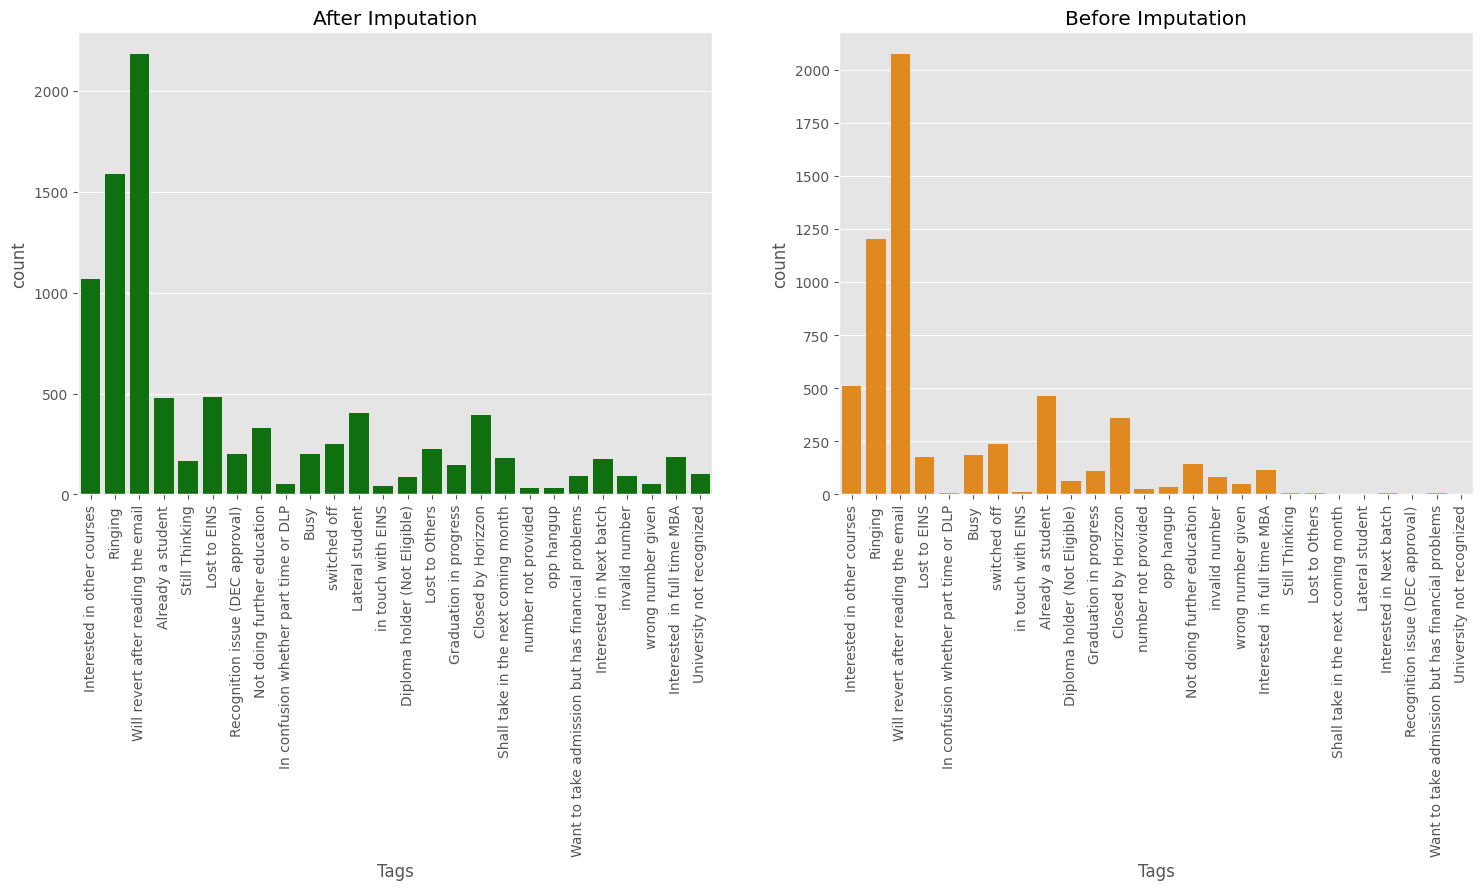

In [84]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.title("After Imputation")
sns.countplot(impute_df['Tags'].fillna("Will revert after reading the email"), color = 'g')
plt.xticks(rotation = "vertical")
plt.subplot(122)
plt.title("Before Imputation")
sns.countplot(cat_df_copy['Tags'], color = 'darkorange')
plt.xticks(rotation = "vertical")
plt.show()

Now we are done with the feature engineering so let's merge the data.

In [85]:
final_df = pd.concat([num_df, impute_df], axis = 1)

In [86]:
final_df.head()

Lead Number  Converted  TotalVisits  Total Time Spent on Website  \
0       660737          0          0.0                            0   
1       660728          0          5.0                          674   
2       660727          1          2.0                         1532   
3       660719          0          1.0                          305   
4       660681          1          2.0                         1428   

   Page Views Per Visit                                 Tags    Lead Profile  \
0                   0.0          Interested in other courses     Unspecified   
1                   2.5                              Ringing     Unspecified   
2                   2.0  Will revert after reading the email  Potential Lead   
3                   1.0                              Ringing     Unspecified   
4                   1.0  Will revert after reading the email     Unspecified   

  What matters most to you in choosing a course  \
0                       Better Career Prospects   
1                       Better Career Prospects   
2                       Better Career Prospects   
3                       Better Career Prospects   
4                       Better Career Prospects   

  What is your current occupation How did you hear about X Education  \
0                      Unemployed                        Unspecified   
1                      Unemployed                        Unspecified   
2                         Student                        Unspecified   
3                      Unemployed                      Word Of Mouth   
4                      Unemployed                              Other   

            Specialization         City            Last Activity  \
0              Unspecified  Unspecified  Page Visited on Website   
1              Unspecified  Unspecified             Email Opened   
2  Business Administration       Mumbai             Email Opened   
3    Media and Advertising       Mumbai              Unreachable   
4              Unspecified       Mumbai        Converted to Lead   

      Lead Source              Lead Origin Do Not Email Do Not Call Search  \
0      Olark Chat                      API           No          No     No   
1  Organic Search                      API           No          No     No   
2  Direct Traffic  Landing Page Submission           No          No     No   
3  Direct Traffic  Landing Page Submission           No          No     No   
4          Google  Landing Page Submission           No          No     No   

  Magazine Newspaper Article X Education Forums Newspaper  \
0       No                No                 No        No   
1       No                No                 No        No   
2       No                No                 No        No   
3       No                No                 No        No   
4       No                No                 No        No   

  Digital Advertisement Through Recommendations  \
0                    No                      No   
1                    No                      No   
2                    No                      No   
3                    No                      No   
4                    No                      No   

  Receive More Updates About Our Courses Update me on Supply Chain Content  \
0                                     No                                No   
1                                     No                                No   
2                                     No                                No   
3                                     No                                No   
4                                     No                                No   

  Get updates on DM Content I agree to pay the amount through cheque  \
0                        No                                       No   
1                        No                                       No   
2                        No                                       No   
3                        No                   

In [87]:
final_df = final_df.iloc[:, [0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29, 1]]

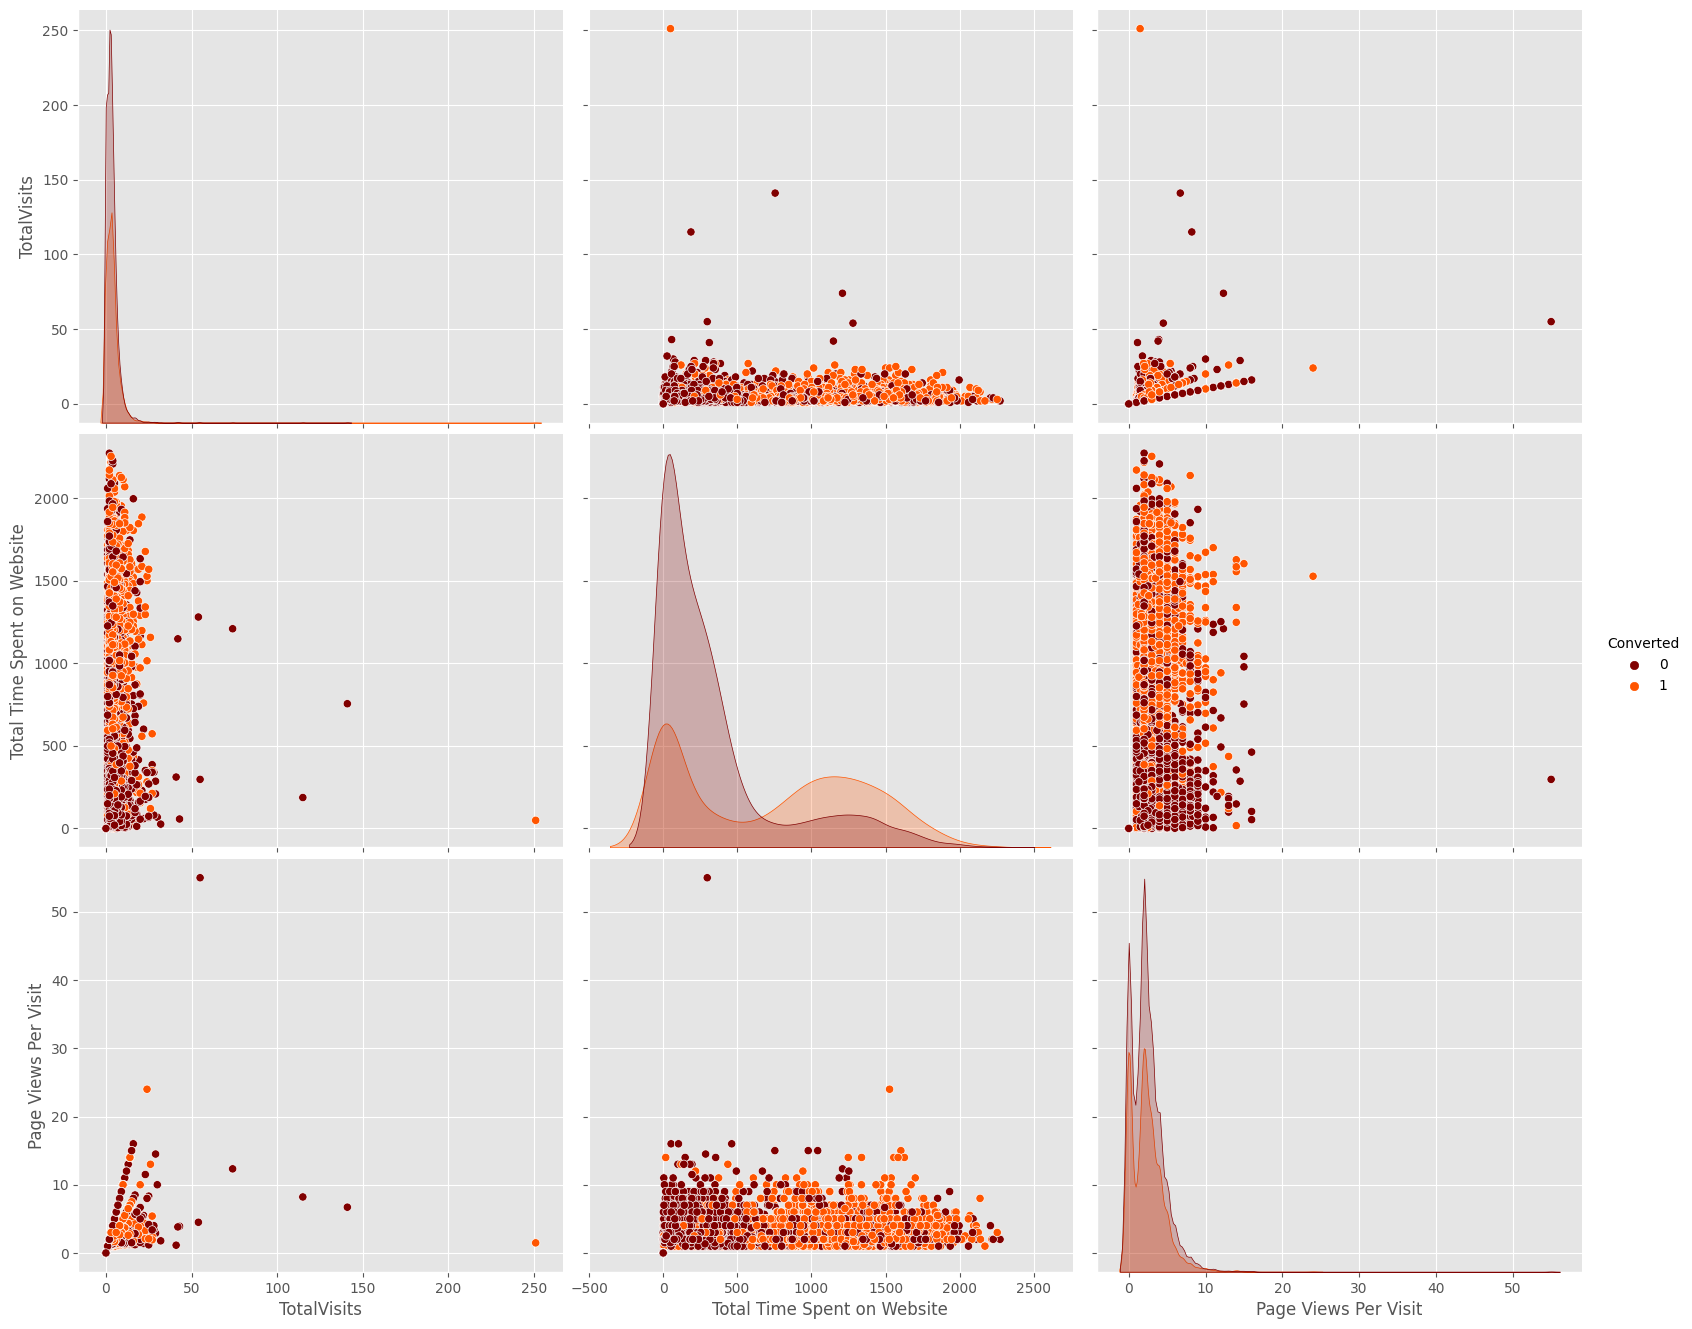

In [88]:
sns.pairplot(final_df.iloc[:, [1,2,3,-1]], hue = 'Converted', palette = 'gist_heat', height = 4.5, aspect = 1.2)

We can clearly see some of the potential outliers in our data also the data seems to be skewed for the different classes.

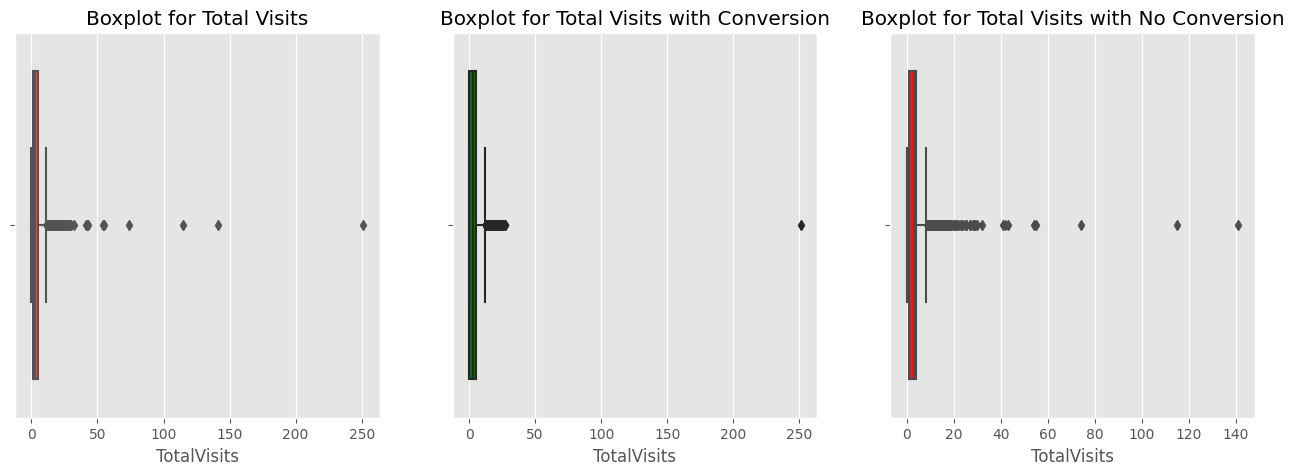

In [89]:
plt.figure(figsize=(16,5))
plt.subplot(131)
plt.title("Boxplot for Total Visits")
sns.boxplot(data = final_df, x = 'TotalVisits')
plt.subplot(132)
plt.title("Boxplot for Total Visits with Conversion")
sns.boxplot(data = final_df.query("Converted == 1"), x = 'TotalVisits', hue = 'Converted', color = 'g')
plt.subplot(133)
plt.title("Boxplot for Total Visits with No Conversion")
sns.boxplot(data = final_df.query("Converted == 0"), x = 'TotalVisits', hue = 'Converted', color = 'r')
plt.show()

As we already see in our pairplot for the extreme values but via this boxplot, now we are clearly see some high extreme values in our data for the Total Visits.

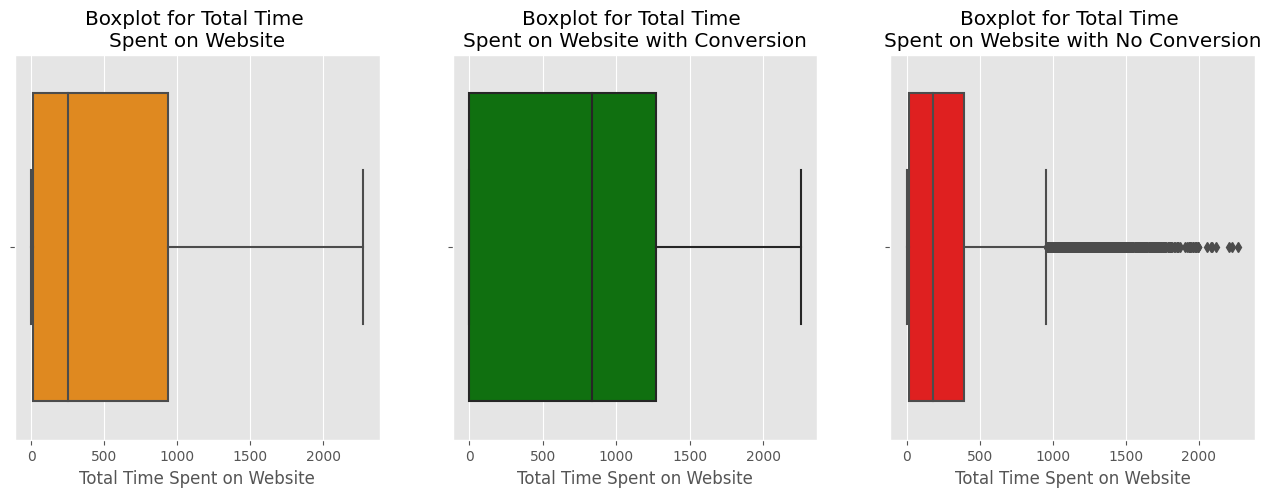

In [90]:
plt.figure(figsize=(16,5))
plt.subplot(131)
plt.title("Boxplot for Total Time \nSpent on Website")
sns.boxplot(data = final_df, x = 'Total Time Spent on Website', color = 'darkorange')
plt.subplot(132)
plt.title("Boxplot for Total Time \nSpent on Website with Conversion")
sns.boxplot(data = final_df.query("Converted == 1"), x = 'Total Time Spent on Website', hue = 'Converted', color = 'g')
plt.subplot(133)
plt.title("Boxplot for Total Time \nSpent on Website with No Conversion")
sns.boxplot(data = final_df.query("Converted == 0"), x = 'Total Time Spent on Website', hue = 'Converted', color = 'r')
plt.show()

Here we can see some potential outliers for the class with **"No Conversion"** but when we look data at the aggregate level the effect of **"No Conversion"** seems to be neutralize because of **"Conversion** class seems to be far less skewed as compared to **"No Conversion"** class.

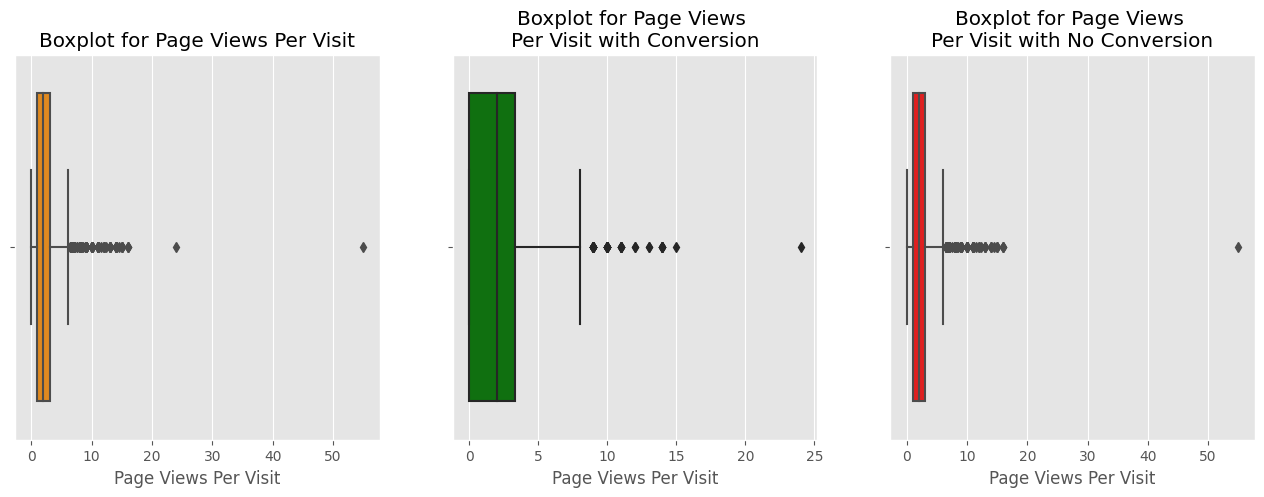

In [91]:
plt.figure(figsize=(16,5))
plt.subplot(131)
plt.title("Boxplot for Page Views Per Visit")
sns.boxplot(data = final_df, x = 'Page Views Per Visit', color = 'darkorange')
plt.subplot(132)
plt.title("Boxplot for Page Views \nPer Visit with Conversion")
sns.boxplot(data = final_df.query("Converted == 1"), x = 'Page Views Per Visit', hue = 'Converted', color = 'g')
plt.subplot(133)
plt.title("Boxplot for Page Views \nPer Visit with No Conversion")
sns.boxplot(data = final_df.query("Converted == 0"), x = 'Page Views Per Visit', hue = 'Converted', color = 'r')
plt.show()

We can also see some extreme values here as well which indicated that we need to fix these outliers before procedding with our analysis.

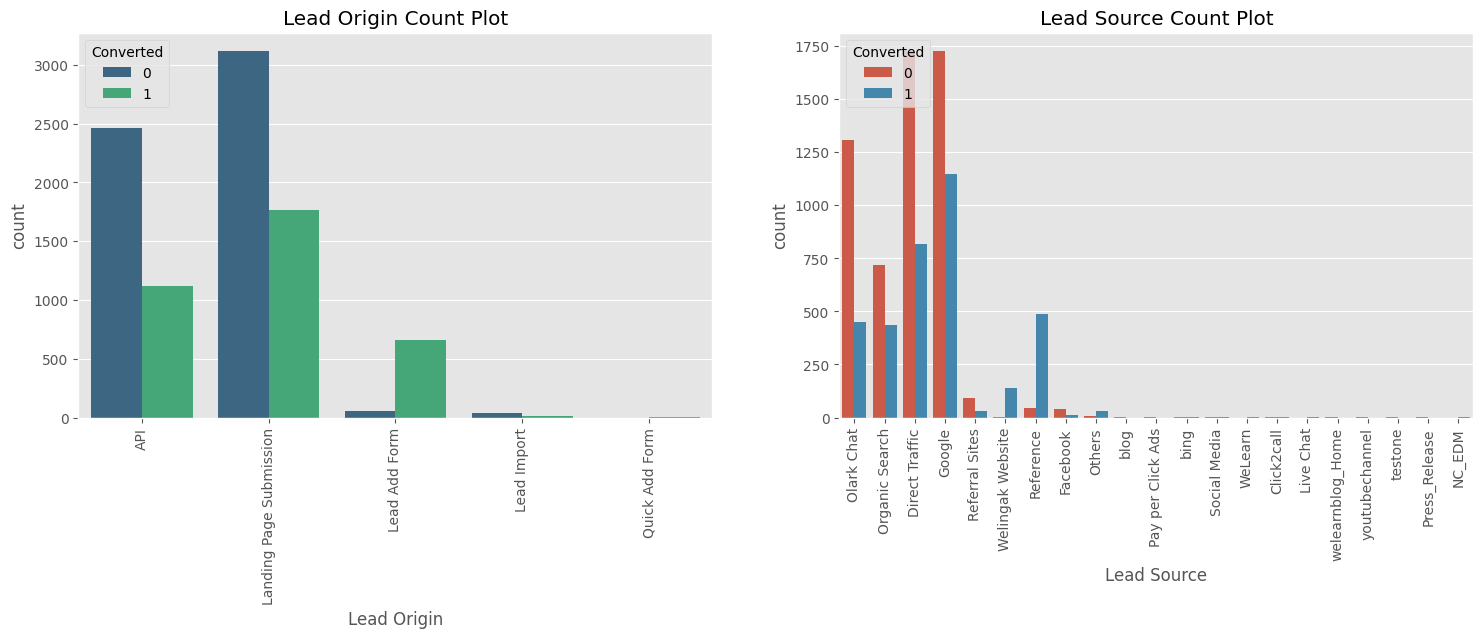

In [92]:
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.title("Lead Origin Count Plot")
sns.countplot(data = final_df, x = 'Lead Origin', hue = 'Converted', palette = 'viridis')
plt.xticks(rotation = '90')
plt.subplot(122)
plt.title("Lead Source Count Plot")
sns.countplot(data = final_df, x = 'Lead Source', hue = 'Converted')
plt.xticks(rotation = '90')
plt.show()

In [93]:
px.parallel_categories(data_frame = final_df, dimensions = ["Lead Source", "Lead Origin", "Converted"],
                       color = 'Page Views Per Visit', color_continuous_scale=px.colors.diverging.Geyser,
                       color_continuous_midpoint=25)

We can clearly see that the users which come "Olark Chat" source usually have a Lead Origin "API" most of them not able to convert. When it comes to "Reference" they have a lead origin of "Lead Add Form" and mostly got converted.

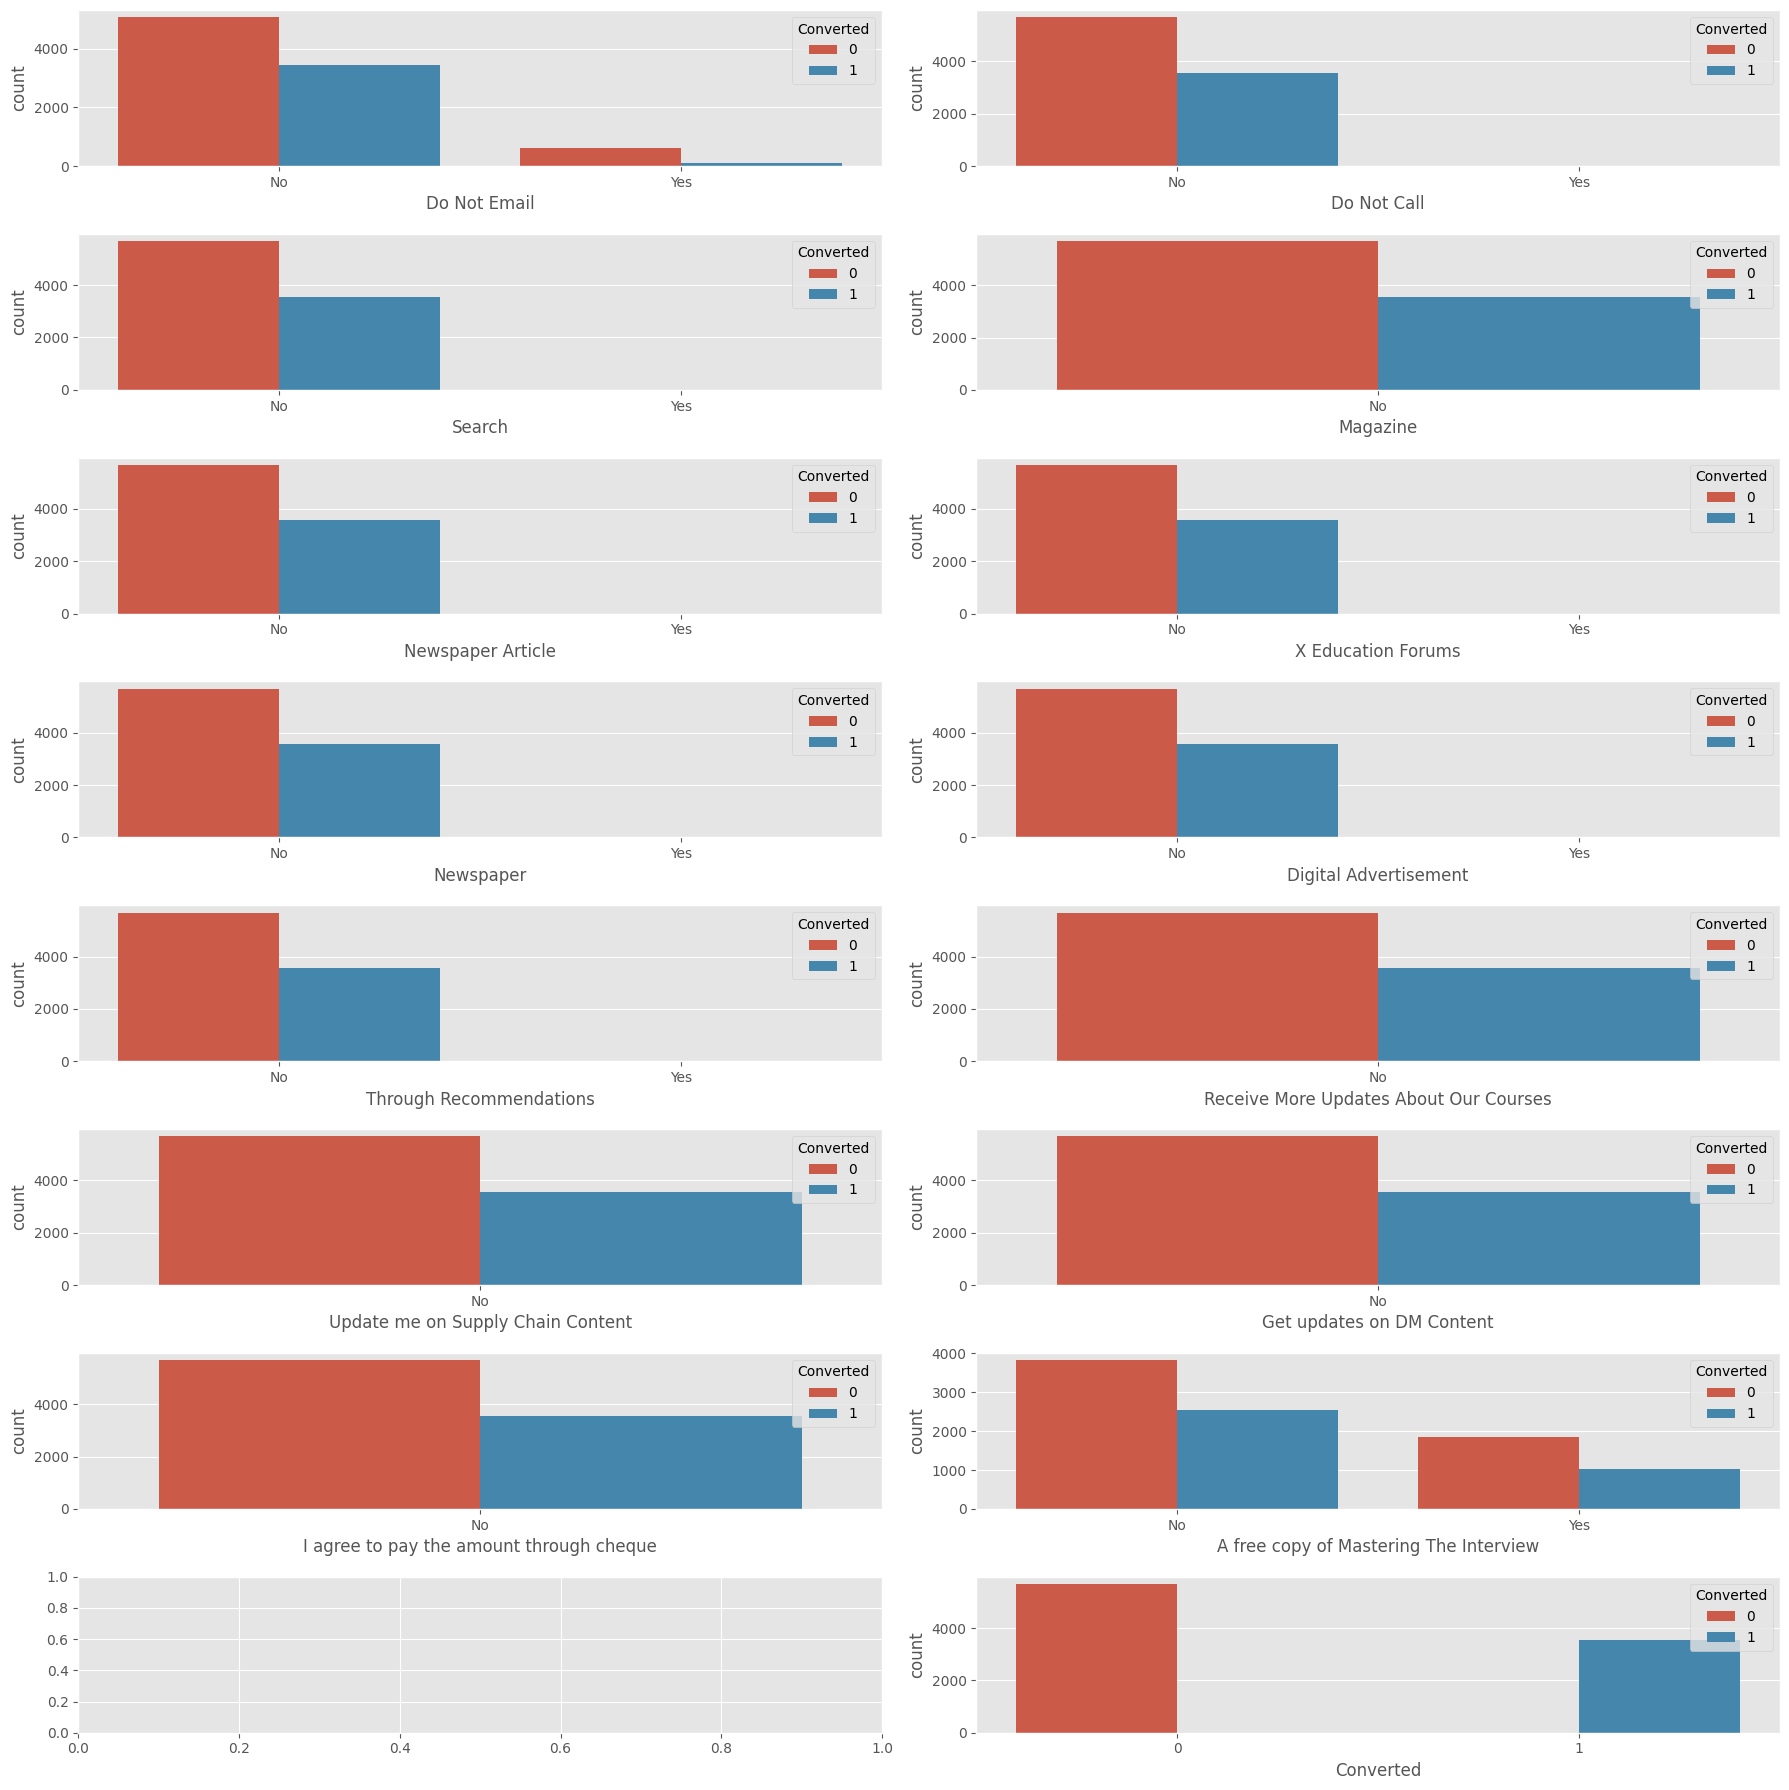

In [94]:
fig, ax = plt.subplots(8, 2, figsize=(18,18))
axes_ = [axes_row for axes in ax for axes_row in axes]

for idx, val in enumerate(final_df.iloc[:, 14:].columns):
    if val == 'Last Notable Activity':
        continue
    else:
        g = sns.countplot(data = final_df, x = val, hue = 'Converted', ax = axes_[idx])
        plt.tight_layout()

Based on that we can see that the proportional of users who not converted is high as compared to the users who converted. Also, the users are not much interested in "Free Copy of Mastering the Interview" which is weired because who does not like freebies. The reason maybe we have large proportion of audience who are "Unemployed" and the only thing they are interested about upskilling themeselves and not giving priority to the interview preparation on the early stage. Also, there are certain columns from which we are not going to inference much information as most of the values are "No" so we will going to drop the same in the later stage.

### Outlier Analysis

In [95]:
def check_outlier(data, col):
    
    #calculating quartile deviation
    q1 = np.quantile(data[col], q = 0.25)
    q3 = np.quantile(data[col], q = 0.75)
    
    #calculating inter-quartile range
    iqr = q3-q1
    
    #calculating lower and upper bound
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    
    #filtering data with outliers
    outlier = data[col][(data[col] < lower_bound) | (data[col] > upper_bound)]
    
    #plotting the result
    plt.figure(figsize=(14,8))
    plt.subplot(211)
    plt.title("%s with Outliers" %(col))
    plt.plot(data[col])
    sns.scatterplot(data = outlier, x = outlier.index, y = outlier.values, marker = 'X', color = 'k', s=70)
    plt.subplot(212)
    sns.boxplot(data = data, x = col, color = 'g')
    plt.show()

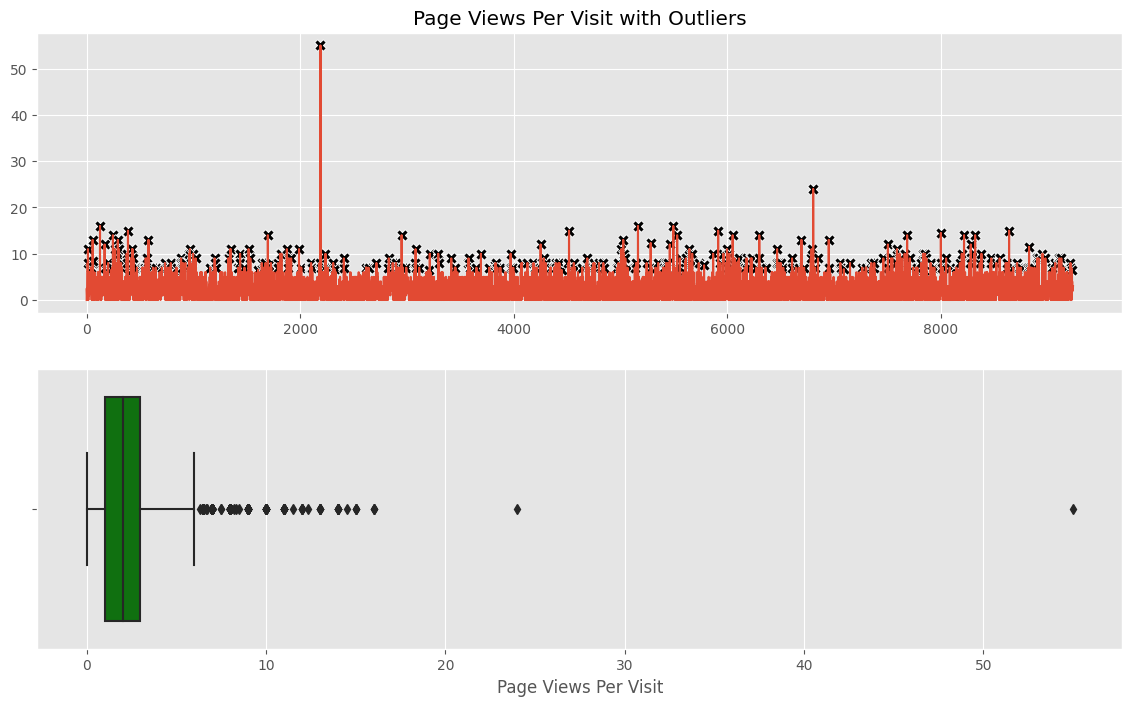

In [96]:
check_outlier(final_df, 'Page Views Per Visit')

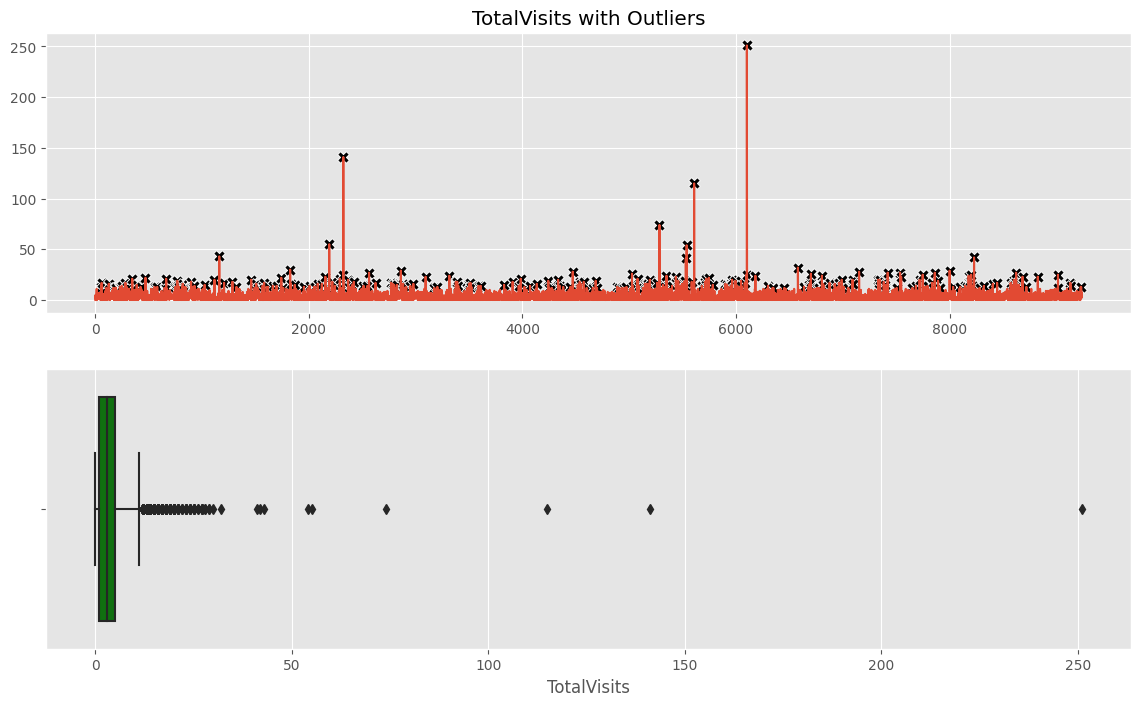

In [97]:
check_outlier(final_df, 'TotalVisits')

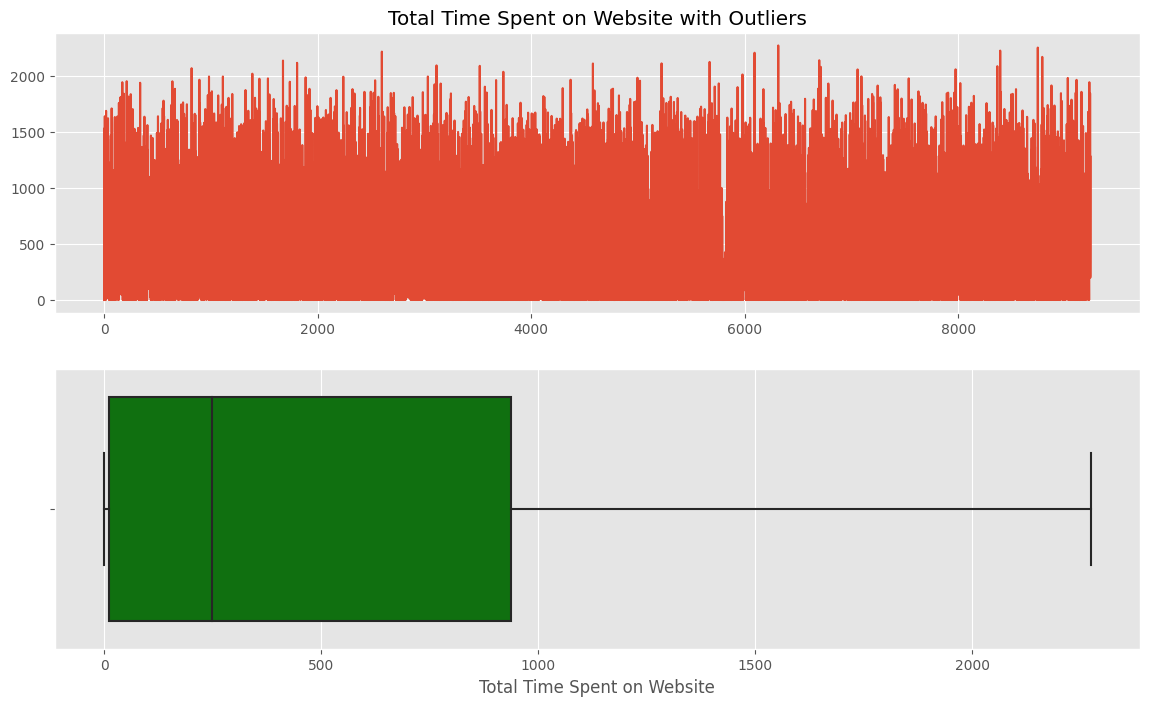

In [98]:
check_outlier(final_df, 'Total Time Spent on Website')

In [99]:
final_df.iloc[:, [1,2,3]].describe(percentiles = [0.01, 0.1, 0.25, 0.75, 0.90, 0.95, 0.99]).T

count        mean         std  min   1%  10%  \
TotalVisits                  9240.0    3.438636    4.819024  0.0  0.0  0.0   
Total Time Spent on Website  9240.0  487.698268  548.021466  0.0  0.0  0.0   
Page Views Per Visit         9240.0    2.357440    2.145781  0.0  0.0  0.0   

                              25%    50%    75%     90%     95%      99%  \
TotalVisits                   1.0    3.0    5.0     7.0    10.0    17.00   
Total Time Spent on Website  12.0  248.0  936.0  1380.0  1562.0  1840.61   
Page Views Per Visit          1.0    2.0    3.0     5.0     6.0     9.00   

                                max  
TotalVisits                   251.0  
Total Time Spent on Website  2272.0  
Page Views Per Visit           55.0

As we can see here how the values are changing from 99 percentile to max which indicates there is something wrong in our data. The sudden increase in our values from 99 percentile to max will make our distribution skewed so we need to fix it.

In [100]:
anomaly_data = final_df.iloc[:, [1,2,3]]

In [101]:
y = final_df.iloc[:, -1]

In [102]:
se = StandardScaler()

In [103]:
le = LogisticRegression(random_state = 42)

In [104]:
scaled_df = pd.DataFrame(se.fit_transform(anomaly_data), columns = anomaly_data.columns)

In [105]:
contamination = [0.1,0.01,0.001,0.05,0.005,0.0001]
k_neighbor = [3,5,7,9, 12, 15, 18, 21, 25]

In [106]:
lof_params = list(product(contamination, k_neighbor))

In [107]:
scores = []

In [108]:
for c, k in lof_params:
    
    lof = LocalOutlierFactor(n_neighbors=k, contamination=c, n_jobs = -1)
    predict = lof.fit_predict(scaled_df)
    mask = pd.DataFrame(predict)
    mask.columns = ["anomaly"]
    filter_df = pd.concat([scaled_df, mask], axis = 1).query('anomaly == 1').reset_index().drop("index", axis = 1)
    filter_y = pd.concat([y, mask], axis = 1).query('anomaly == 1').reset_index().drop("index", axis = 1)
    filter_df = filter_df.iloc[:, :3]
    filter_y = filter_y.iloc[:, :1]
    cv_score = cross_val_score(estimator= le, X = filter_df, y = filter_y, cv = 10, scoring = 'accuracy')
    scores.append(np.mean(cv_score))
    print(np.mean(cv_score))

0.7102001469499213
0.7129663056558363
0.7124851025178192
0.712966161020087
0.7133277503934092
0.7144086133481442
0.714288565676201
0.7121239470517449
0.7130853408775341
0.715222635836495
0.7164120959931126
0.7158660066243379
0.7160848250050819
0.7158663653429947
0.7166312730925135
0.716412335138884
0.7157563582881945
0.7153191998182491
0.7158179848320694
0.7157374315825019
0.7163596966413868
0.7164680390032502
0.7165763813651137
0.7164680390032502
0.7164680390032502
0.7165763813651137
0.7164680390032502
0.7133748308454739
0.714629106786181
0.7140593709659405
0.715313127430176
0.7151992322137749
0.7155407879938598
0.7148568972189826
0.7157676693428362
0.7139456056186576
0.7159474578671576
0.7160892037659081
0.7153276245446374
0.7157625254293418
0.7157625254293418
0.7159803898377253
0.7157628802573686
0.7157627619813597
0.7156537115011591
0.7162049218387245
0.7161255411255412
0.7160966967304996
0.7160966967304996
0.7162049218387246
0.7162049218387246
0.7162049218387246
0.7162049218387246

In [109]:
param_df = pd.DataFrame(lof_params, columns = ["contamination", "neighbors"])

In [110]:
scores_df = pd.DataFrame(scores, columns = ["scores"])

In [111]:
lof_perf_df = pd.concat([param_df, scores_df], axis = 1)

In [112]:
lof_pivot = pd.pivot_table(data = lof_perf_df, index = 'contamination', columns = 'neighbors', values = 'scores')

In [113]:
lof_pivot

neighbors            3         5         7         9         12        15  \
contamination                                                               
0.0001         0.716205  0.716126  0.716097  0.716097  0.716205  0.716205   
0.0010         0.715818  0.715737  0.716360  0.716468  0.716576  0.716468   
0.0050         0.715947  0.716089  0.715328  0.715763  0.715763  0.715980   
0.0100         0.715223  0.716412  0.715866  0.716085  0.715866  0.716631   
0.0500         0.713375  0.714629  0.714059  0.715313  0.715199  0.715541   
0.1000         0.710200  0.712966  0.712485  0.712966  0.713328  0.714409   

neighbors            18        21        25  
contamination                                
0.0001         0.716205  0.716205  0.716205  
0.0010         0.716468  0.716576  0.716468  
0.0050         0.715763  0.715763  0.715654  
0.0100         0.716412  0.715756  0.715319  
0.0500         0.714857  0.715768  0.713946  
0.1000         0.714289  0.712124  0.713085

<AxesSubplot:xlabel='neighbors', ylabel='contamination'>

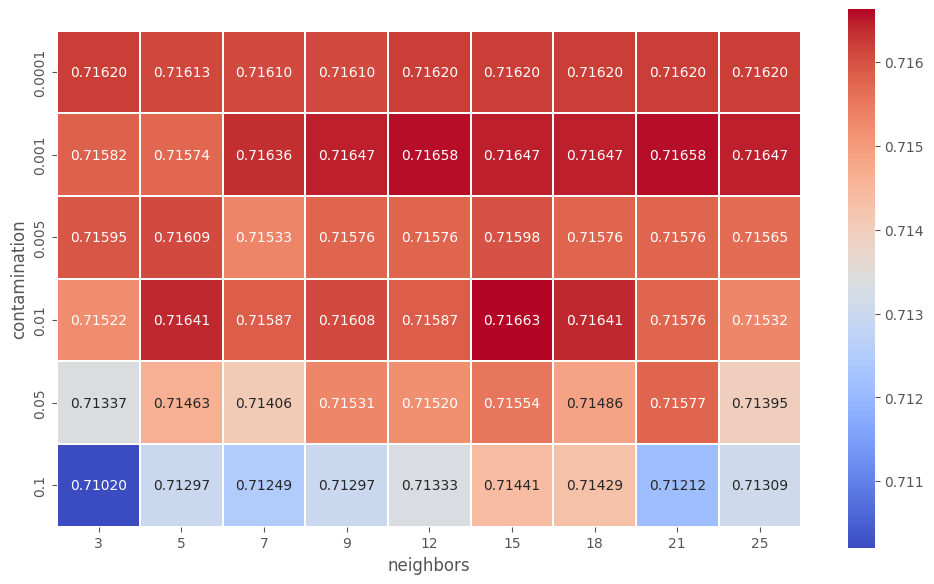

In [114]:
plt.figure(figsize=(12,7))
sns.heatmap(lof_pivot, annot = True, fmt = ".5f", cmap = 'coolwarm', square = True, linewidths=0.025)

In [115]:
lof = LocalOutlierFactor(contamination=0.001, n_neighbors=21, n_jobs = -1)

In [116]:
lof_fit = lof.fit_predict(scaled_df)

In [117]:
anomaly_label = pd.DataFrame(lof_fit, columns = ["anomaly"])

In [118]:
final_df.loc[:, "anomaly"] = anomaly_label

In [119]:
final_df.head()

Lead Number  TotalVisits  Total Time Spent on Website  \
0       660737          0.0                            0   
1       660728          5.0                          674   
2       660727          2.0                         1532   
3       660719          1.0                          305   
4       660681          2.0                         1428   

   Page Views Per Visit                                 Tags    Lead Profile  \
0                   0.0          Interested in other courses     Unspecified   
1                   2.5                              Ringing     Unspecified   
2                   2.0  Will revert after reading the email  Potential Lead   
3                   1.0                              Ringing     Unspecified   
4                   1.0  Will revert after reading the email     Unspecified   

  What matters most to you in choosing a course  \
0                       Better Career Prospects   
1                       Better Career Prospects   
2                       Better Career Prospects   
3                       Better Career Prospects   
4                       Better Career Prospects   

  What is your current occupation How did you hear about X Education  \
0                      Unemployed                        Unspecified   
1                      Unemployed                        Unspecified   
2                         Student                        Unspecified   
3                      Unemployed                      Word Of Mouth   
4                      Unemployed                              Other   

            Specialization         City            Last Activity  \
0              Unspecified  Unspecified  Page Visited on Website   
1              Unspecified  Unspecified             Email Opened   
2  Business Administration       Mumbai             Email Opened   
3    Media and Advertising       Mumbai              Unreachable   
4              Unspecified       Mumbai        Converted to Lead   

      Lead Source              Lead Origin Do Not Email Do Not Call Search  \
0      Olark Chat                      API           No          No     No   
1  Organic Search                      API           No          No     No   
2  Direct Traffic  Landing Page Submission           No          No     No   
3  Direct Traffic  Landing Page Submission           No          No     No   
4          Google  Landing Page Submission           No          No     No   

  Magazine Newspaper Article X Education Forums Newspaper  \
0       No                No                 No        No   
1       No                No                 No        No   
2       No                No                 No        No   
3       No                No                 No        No   
4       No                No                 No        No   

  Digital Advertisement Through Recommendations  \
0                    No                      No   
1                    No                      No   
2                    No                      No   
3                    No                      No   
4                    No                      No   

  Receive More Updates About Our Courses Update me on Supply Chain Content  \
0                                     No                                No   
1                                     No                                No   
2                                     No                                No   
3                                     No                                No   
4                                     No                                No   

  Get updates on DM Content I agree to pay the amount through cheque  \
0                        No                                       No   
1                        No                                       No   
2                        No                                       No   
3                        No                                       No   
4                        No             

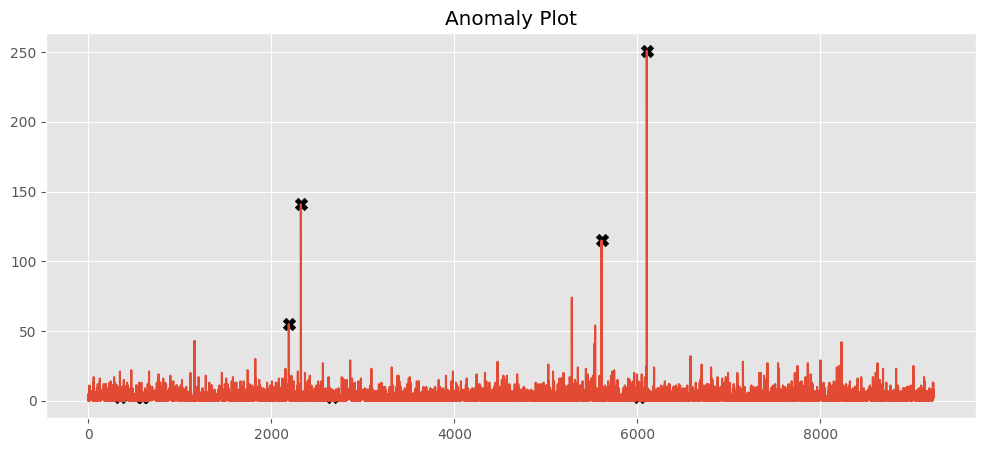

In [120]:
plt.figure(figsize=(12,5))
plt.title("Anomaly Plot")
plt.plot(final_df["TotalVisits"])
plt.scatter(x = final_df[final_df["anomaly"] == -1]["TotalVisits"].index, y = final_df[final_df["anomaly"] == -1]["TotalVisits"].values, marker = "X", color = 'k', s = 80)

In [121]:
anomaly_idx = final_df[final_df["anomaly"] == -1].index

In [122]:
final_df.shape

(9240, 31)

In [123]:
filter_df = final_df.drop(anomaly_idx, axis = 0).reset_index().drop("index", axis = 1)

In [124]:
filter_df.drop("anomaly", axis = 1, inplace = True)

In [125]:
filter_df.iloc[:, :-1].describe()

Lead Number  TotalVisits  Total Time Spent on Website  \
count    9230.000000  9230.000000                  9230.000000   
mean   617169.918960     3.379523                   488.069339   
std     23401.760534     3.594001                   548.153831   
min    579533.000000     0.000000                     0.000000   
25%    596475.750000     1.000000                    12.000000   
50%    615470.500000     3.000000                   249.000000   
75%    637372.250000     5.000000                   936.750000   
max    660737.000000    74.000000                  2272.000000   

       Page Views Per Visit  
count           9230.000000  
mean               2.350959  
std                2.074395  
min                0.000000  
25%                1.000000  
50%                2.000000  
75%                3.000000  
max               24.000000

We are at the end of our EDA, Feature Engineering & Outlier Analysis Part but for the Outlier Analysis, we have detected some extreme outliers using LOF and removed them from our data but still there are some extreme values based on the boxplot but for this analysis, we are keeping those extreme values and build our model if our model did not perform well than in that case we will going to tweak our model by removing these extreme values or applying winzoriazation on it.

In [126]:
drop_cols = ["Do Not Call", "Search", "Magazine", "Newspaper Article", "X Education Forums", "Newspaper",
             "Digital Advertisement", "Through Recommendations", "Receive More Updates About Our Courses",
            "Update me on Supply Chain Content", "Get updates on DM Content", "I agree to pay the amount through cheque"]

In [127]:
filter_df.drop(drop_cols, axis = 1, inplace = True)

In [128]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [129]:
cat_feature = filter_df.dtypes[filter_df.dtypes == 'object'].keys()

In [130]:
cat_feature

Index(['Tags', 'Lead Profile', 'What matters most to you in choosing a course',
       'What is your current occupation', 'How did you hear about X Education',
       'Specialization', 'City', 'Last Activity', 'Lead Source', 'Lead Origin',
       'Do Not Email', 'A free copy of Mastering The Interview',
       'Last Notable Activity'],
      dtype='object')

In [131]:
num_feature = filter_df.dtypes[(filter_df.dtypes == 'int64') | (filter_df.dtypes == 'float64')].keys()[[1,2,3]]

In [132]:
num_feature

Index(['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit'], dtype='object')

In [133]:
se = StandardScaler()

In [134]:
encode_num = pd.DataFrame(se.fit_transform(filter_df[num_feature]), columns = num_feature)

In [135]:
famd_df = pd.concat([encode_num, filter_df[cat_feature]], axis = 1)

### Dimension Reduction - FAMD (Factor Analysis for Mixed Data)

In [136]:
from prince import FAMD

In [137]:
inertia = []

In [138]:
n_components = np.arange(2,101,1)

In [142]:
for i in n_components:
    famd = FAMD(n_components=i, random_state=101).fit(famd_df)
    eigenvalues = famd.eigenvalues_
    total_variance = sum(eigenvalues)
    explained_variance = [eigval / total_variance for eigval in eigenvalues]
    inertia.append(explained_variance)

In [143]:
cumsum_inertia = []
for i in inertia:
    cumsum_inertia.append(np.sum(i)*100)

In [144]:
px.area(y = cumsum_inertia, x = n_components, title = "Inertia v/s Components")

We have several algorithms and techniques available to use but most of them will be computationally so expensive due to high dimensional dataset. As we can see here, if we try to minimize the dimension to a very large extent then we may end up losing some information which is definitely we don't want, so we need to figure out some other way to resolve this issue.

In [145]:
encoded_cat_df = pd.get_dummies(filter_df[cat_feature], drop_first = True)

In [146]:
final_encoded_df = pd.concat([encode_num, encoded_cat_df], axis = 1)

In [147]:
final_encoded_df.head()

TotalVisits  Total Time Spent on Website  Page Views Per Visit  Tags_Busy  \
0    -0.940374                    -0.890436             -1.133384          0   
1     0.450908                     0.339213              0.071852          0   
2    -0.383861                     1.904552             -0.169195          0   
3    -0.662118                    -0.333992             -0.651290          0   
4    -0.383861                     1.714813             -0.651290          0   

   Tags_Closed by Horizzon  Tags_Diploma holder (Not Eligible)  \
0                        0                                   0   
1                        0                                   0   
2                        0                                   0   
3                        0                                   0   
4                        0                                   0   

   Tags_Graduation in progress  Tags_In confusion whether part time or DLP  \
0                            0                                           0   
1                            0                                           0   
2                            0                                           0   
3                            0                                           0   
4                            0                                           0   

   Tags_Interested  in full time MBA  Tags_Interested in Next batch  \
0                                  0                              0   
1                                  0                              0   
2                                  0                              0   
3                                  0                              0   
4                                  0                              0   

   Tags_Interested in other courses  Tags_Lateral student  Tags_Lost to EINS  \
0                                 1                     0                  0   
1                                 0                     0                  0   
2                                 0                     0                  0   
3                                 0                     0                  0   
4                                 0                     0                  0   

   Tags_Lost to Others  Tags_Not doing further education  \
0                    0                                 0   
1                    0                                 0   
2                    0                                 0   
3                    0                                 0   
4                    0                                 0   

   Tags_Recognition issue (DEC approval)  Tags_Ringing  \
0                                      0             0   
1                                      0             1   
2                                      0             0   
3                                      0             1   
4                                      0             0   

   Tags_Shall take in the next coming month  Tags_Still Thinking  \
0                                         0                    0   
1                                         0                    0   
2                                         0                    0   
3                                         0                    0   
4                                         0                    0   

   Tags_University not recognized  \
0                               0   
1                               0   
2                               0   
3                               0   
4                               0   

   Tags_Want to take admission but has financial problems  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   Tags_Will revert after reading the e

In [148]:
from sklearn.feature_selection import mutual_info_classif

In [149]:
filter_df.iloc[:, -1]

0       0
1       0
2       1
3       0
4       1
       ..
9225    1
9226    0
9227    0
9228    1
9229    1
Name: Converted, Length: 9230, dtype: int64

In [150]:
importances = mutual_info_classif(final_encoded_df, filter_df.iloc[:, -1])

In [151]:
mutual_score = pd.DataFrame([ final_encoded_df.columns, importances], index = ["Features", "Importance"]).T.sort_values(by = "Importance", ascending = False).reset_index().drop("index", axis = 1)

In [152]:
low_score_col = mutual_score[mutual_score["Importance"] == 0].Features.values

In [153]:
high_score_col = mutual_score[mutual_score["Importance"] > 0].Features.values

In [154]:
classif_data = final_encoded_df[high_score_col]

In [155]:
X = classif_data
y = filter_df.iloc[:, -1]

In [156]:
from sklearn.model_selection import train_test_split

In [157]:
train, test = train_test_split(pd.concat([X, y], axis = 1), test_size = 0.25)

In [158]:
train.to_csv("train.csv")
test.to_csv("test.csv")